# Any/All Countries
In this file, we replicate and extend the analyis done for the US to all countries in our sample

#### Import

In [1]:
#Import
import os
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

#Manage time
from datetime import datetime, timedelta

#Plot
import seaborn as sns
import matplotlib.pyplot as plt

#Ip widget
import ipywidgets as widgets

In [2]:
#Prevent warnings
import warnings
warnings.filterwarnings("ignore")

#### 1. Download Factor description and market returns

In [3]:
#Download factor description
desc_factor = pd.read_excel(r"C:\EDHEC\M2\Cours\Master thesis\Data\Git_Jessen\Factor Details.xlsx")

#Download markt returns
market_ret = pd.read_csv(r"C:\EDHEC\M2\Cours\Master thesis\Data\Git_Jessen\market_returns.csv")

#### 2. Download country class

In [4]:
class_country = pd.read_excel(r"C:\EDHEC\M2\Cours\Master thesis\Data\Git_Jessen\Country Classification.xlsx")

In [5]:
#Country ISO code
iso_list=[]

#Country for which we have data
for cnt in class_country["excntry"].values.tolist():
    try:
        main_p = r"C:\EDHEC\M2\Cours\Master thesis\Data\Git_Jessen\Country Factors"
        path = os.path.join(main_p,cnt+".csv")
        cnt_lms = pd.read_csv(path)
        iso_list.append(cnt)
    except:
        pass

#### 3. Filter Country with not enough datapoints for study

In [6]:
#Download Country factor returns
toremove_list = []
for iso in iso_list:
    main_p = r"C:\EDHEC\M2\Cours\Master thesis\Data\Git_Jessen\Country Factors"
    path = os.path.join(main_p,iso+".csv")
    cnt_lms = pd.read_csv(path)
    
    #Find charac with the most datapoints
    size_max = cnt_lms.groupby("characteristic").size().max()

    #50% of data over 11 years for monthly
    limit = (6*12)
    if size_max < limit:
        toremove_list.append(iso)

#Update ISO list
iso_list = [x for x in iso_list if x not in toremove_list]
        
print(len(toremove_list), "do not present sufficient data")
print(toremove_list)

19 do not present sufficient data
['BHR', 'BGD', 'ROU', 'OMN', 'TTO', 'HRV', 'KEN', 'CZE', 'HUN', 'JOR', 'JAM', 'SVN', 'IRN', 'ISL', 'LKA', 'LUX', 'UKR', 'CYP', 'ZWE']


#### 4. Mapping
- Significant alpha for OLS (p-value)
- Alpha same sign as for the US market: US benchmark

In [7]:
def mapping(iso):
    #Download markt returns
    cnt_ret = market_ret[market_ret["excntry"]== iso].reset_index().drop(columns=["index"])
    cnt_ret["eom"] = pd.to_datetime(cnt_ret["eom"], format="%Y-%m-%d")#Convert eom to datetime

    #Download Country factor returns
    main_p = r"C:\EDHEC\M2\Cours\Master thesis\Data\Git_Jessen\Country Factors"
    path = os.path.join(main_p,iso+".csv")
    cnt_lms = pd.read_csv(path)
    cnt_lms["eom"] = pd.to_datetime(cnt_lms["eom"], format="%Y-%m-%d")#Convert eom to datetime

    #For now only keep equally weighted & start in 1927
    factor_df = cnt_lms[["eom","ret_ew", "characteristic"]]
    market_df = cnt_ret[["eom", "mkt_ew"]]

    #Get the year 
    factor_df["year"] = factor_df["eom"].dt.year
    market_df["year"] = market_df["eom"].dt.year

    #Only keep year after 1960
    #Adjust because market data only goes to 2020
    factor_df = factor_df[(factor_df["year"]>1960) & (factor_df["year"]<2021)]
    market_df = market_df[market_df["year"]>1960]
    
    #Group by characteristics
    factor_df = factor_df.groupby("characteristic")
    
    # Create empty lists to store the results
    results=[]
    
    #Loop on the characteristics
    for c in factor_df.groups.keys():   
        #Store the data of the characteristic dataframe
        data_df = factor_df.get_group(c)
        
        #Start & End of in sample period
        in_period = desc_factor[desc_factor["abr_jkp"]==c]["in-sample period"].values[0].split("-")
        start_in = int(in_period[0])
        end_in = int(in_period[1])
        
        #Get the period for each df
        data_df = data_df[(data_df["year"]>start_in)
                          & (data_df["year"]<end_in)][["eom","ret_ew"]]
        market_c_df = market_df[(market_df["year"]>start_in)
                              & (market_df["year"]<end_in)][["eom","mkt_ew"]]
        
        #Enough datapoints: 2 years of data needed
        if data_df.empty:
            min_date = 0
        else:
            min_date = int(data_df["eom"].dt.year.min())
    
        if int(min_date) <= (end_in-2):
            #Avoid missmatch in date and size lenght
            merge_df = pd.merge(data_df, market_c_df, on="eom", how="inner")
            
            ################
            ###REGRESSION###
            ################
            #Test - Missing data can lead to missmatch in length raising an error
            try:
                # Fit a linear regression model to the data
                # ft = alpha + beta*rm
                #Compare to the beta method we invert x and y
                X = sm.add_constant(merge_df["mkt_ew"].tolist())
                model = sm.OLS(merge_df["ret_ew"].tolist(), X).fit() #sm.OLS(y, X)

                # Extract the alpha and beta coefficients
                alpha = model.params[0]
                beta = model.params[1]

                #pvalue alpha
                p_val = model.pvalues[0]

                # Append the results to the list
                results.append({'Characteristic': c, 'alpha': alpha, 'p_value': p_val})
            except:
                pass
            
    results_df = pd.DataFrame(results)

    return(results_df)

##### 4.a Selecting significant characteristics with the right return direction

In [8]:
#Benchmark
us = mapping("USA")
#Characteristic that are statistically significants
us = us[us["p_value"]<0.05]
#Add mapping for alpha sign 
us["sign"] = us["alpha"].apply(lambda x: 1 if x > 0 else -1)

In [9]:
#Empty list to store the info
cnt_info =[]

#Loop on countries in our dataset
for cnt in iso_list:
    cnt_data = mapping(cnt)
    #filter on p_value
    cnt_data = cnt_data[cnt_data["p_value"]<0.05]
    
    #add column for sign
    cnt_data["sign"] = cnt_data["alpha"].apply(lambda x: 1 if x > 0 else -1)
    #Merge and select charac with same sign
    merge_df = pd.merge(cnt_data, us, on="Characteristic")
    merge_df = merge_df[merge_df["sign_y"] == merge_df["sign_y"]]
    
    cnt_info.append({"country":cnt, "nb_charac": merge_df.shape[0], "list_c": merge_df["Characteristic"].tolist()})

cnt_df = pd.DataFrame(cnt_info)

In [10]:
#Update iso list to only keep countries where we do have characteristics to study
iso_list = cnt_df[cnt_df["nb_charac"] != 0]["country"].tolist()
print(iso_list)

['USA', 'CHN', 'JPN', 'HKG', 'GBR', 'IND', 'TWN', 'KOR', 'CAN', 'AUS', 'DEU', 'FRA', 'SWE', 'CHE', 'THA', 'IDN', 'BRA', 'SGP', 'MYS', 'ITA', 'ZAF', 'ESP', 'MEX', 'RUS', 'ISR', 'SAU', 'NLD', 'PHL', 'NOR', 'CHL', 'BEL', 'TUR', 'DNK', 'FIN', 'ARE', 'POL', 'NZL', 'VNM', 'AUT', 'QAT', 'KWT', 'PER', 'COL', 'GRC', 'PAK', 'MAR', 'IRL', 'EGY', 'ARG', 'NGA', 'PRT']


#### 5. Creation of get_data and get_corr
**get_data** takes as input the **iso code** of a country. It will perform the following action:
- Download factor returns for the country
- Select the market the market returns of the country from market_ret.
- Group data by year (only keep above 1960)
- Perform the Fama Macbeth regression for each year and each characteristics
- Perform winsorization

**get_corr** takes as input the **iso code** of a country. It will perform the following action:
- Compute the corraletion between the market and each factor for the in and out-sample period.

In [11]:
def get_data(iso):
    #Download markt returns
    cnt_ret = market_ret[market_ret["excntry"]== iso ].reset_index().drop(columns=["index"])
    cnt_ret["eom"] = pd.to_datetime(cnt_ret["eom"], format="%Y-%m-%d")#Convert eom to datetime

    #Download Country factor returns
    main_p = r"C:\EDHEC\M2\Cours\Master thesis\Data\Git_Jessen\Country Factors"
    path = os.path.join(main_p,iso+".csv")
    cnt_lms = pd.read_csv(path)
    cnt_lms["eom"] = pd.to_datetime(cnt_lms["eom"], format="%Y-%m-%d")#Convert eom to datetime

    #For now only keep equally weighted & start in 1927
    factor_df = cnt_lms[["eom","ret_ew", "characteristic"]]
    market_df = cnt_ret[["eom", "mkt_ew"]]
    
    #Only keep the characteristic defined above in mapping
    charac_interest = cnt_df[cnt_df["country"] == iso]["list_c"].tolist()[0]
    factor_df = factor_df[factor_df["characteristic"].isin(charac_interest)]

    #Get the year 
    factor_df["year"] = factor_df["eom"].dt.year
    market_df["year"] = market_df["eom"].dt.year

    #Only keep year after 1960
    #Adjust because market data only goes to 2020
    factor_df = factor_df[(factor_df["year"]>1960) & (factor_df["year"]<2021)]
    market_df = market_df[market_df["year"]>1960]

    #Group by year
    factor_yearly = factor_df.groupby(["year", "characteristic"])
    market_yearly = market_df.groupby("year")

    # Create empty lists to store the results
    results=[]
    
    ################################
    #######   Regression ###########
    ################################
    
    # Loop through each year and characteristics
    for name, data in factor_yearly:
        year, charac = name

        # Get the market and portfolio returns for the current year and portfolio
        market_returns = market_yearly.get_group(year)["mkt_ew"].tolist()
        fct_returns = data["ret_ew"].tolist()

        #Test - Missing data can lead to missmatch in length raising an error
        try:
            # Fit a linear regression model to the data
            X = sm.add_constant(fct_returns)
            model = sm.OLS(market_returns, X).fit() #sm.OLS(y, X)

            # Extract the alpha and beta coefficients
            alpha = model.params[0]
            beta = model.params[1]

            # Append the results to the list
            results.append({'Year': year, 'Characteristic': charac, 'Alpha': alpha, 'Beta': beta})

        except:
            pass

    # Convert to a dataframe to store the results
    results_df = pd.DataFrame(results)
    
    ###################
    ### Winsorization##
    ###################
    
    #Adjust for extremes values
    results_adj_df = results_df.copy() #create df to store data

    for c in results_df["Characteristic"].unique():
        #create copy df 
        temp_df = results_df[(results_df["Characteristic"] == c)].copy()
        #Winsorization 90%
        temp_df["Beta"] = winsorize(temp_df["Beta"], limits=(0.05, 0.05))

        #Add results
        results_adj_df[(results_adj_df["Characteristic"] == c)] = temp_df

    return(results_adj_df)

#### 5. Creation of the plotting function
This function performs the following action
- Create a scatter plot with the betas
- Add a vertical lin for the discovery year
- Compute the average of the betas for the in-sample and out-sample period

In [12]:
def plot_charac_adj(results_df, c):#Select a df and charateristic
    
    #In sample period
    in_period = desc_factor[desc_factor["abr_jkp"]==c]["in-sample period"].values[0].split("-")
    start_in = in_period[0]
    disc_year = in_period[1]
    
    #Avg of betas before and after the discovery
    bef_avg = results_df[(results_df["Characteristic"]==c) 
                         & (results_df["Year"]<=int(disc_year))
                         & (results_df["Year"]>int(start_in))]["Beta"].mean()
    
    after_avg = results_df[(results_df["Characteristic"]==c) 
                           & (results_df["Year"]>int(disc_year))]["Beta"].mean()
    
    # Create a scatter plot of the beta values over time
    fig, ax = plt.subplots(figsize=(12,6))
    
    #Define X and Y
    X = results_df[(results_df["Characteristic"]==c) 
                              & (results_df["Year"]>int(start_in))]['Year']
    Y = results_df[(results_df["Characteristic"]==c)
                             & (results_df["Year"]>int(start_in))]['Beta']
    ax.scatter(X, Y)#Scatter plot
    
    #pct for hline limit
    pct_xlim = results_df[(results_df["Characteristic"]==c) 
                          & (results_df["Year"]<=int(disc_year))
                          & (results_df["Year"]>int(start_in))].shape[0]/ results_df[(results_df["Characteristic"]==c)
                                                                                    & (results_df["Year"]>int(start_in))].shape[0]
                       
    #Hline of average
    ax.axhline(bef_avg, xmax = pct_xlim, color = "g", label="Before D")
    ax.axhline(after_avg, xmin = pct_xlim, color = "orange", label="After D")
    
    #Annotate Hline values
    min_year = int(start_in)
    ax.annotate(str(round(bef_avg,2)),xy=(min_year,bef_avg + 0.2), color = "g")
    ax.annotate(str(round(after_avg,2)),xy=(int(disc_year) + 1,after_avg + 0.2), color = "orange")
    
    #Vertical line - Discovery year
    ax.axvline(int(disc_year), color = 'r', linestyle ="dashed", label = 'Year of discovery'+str(disc_year))
    
    #Correlation between market & factor
    


    # Add a title and axis labels
    ax.set_title(c+' - Beta Values Over Time')
    plt.xlabel('Year')
    plt.ylabel('Beta')            
                 
    plt.legend()
    plt.show() 

#### 6. Visualization of characteristics performance per country

##### 6.a Creation of the widget

In [13]:
w_iso = widgets.Dropdown(
    options=iso_list,
    value='USA',
    description='ISO CODE:',
    disabled=False,
    )
display(w_iso)

Dropdown(description='ISO CODE:', options=('USA', 'CHN', 'JPN', 'HKG', 'GBR', 'IND', 'TWN', 'KOR', 'CAN', 'AUS…

##### 6.b Plotting all characteristics

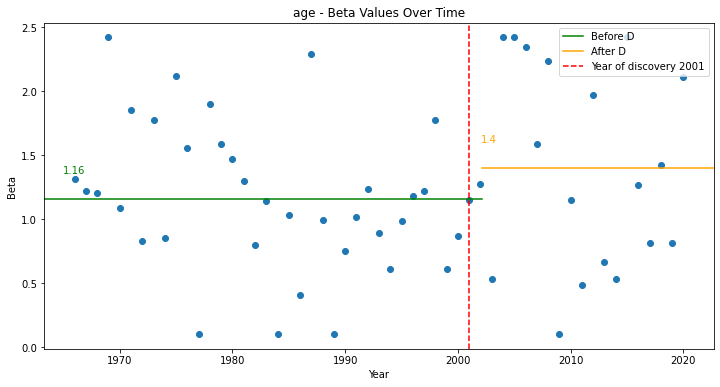

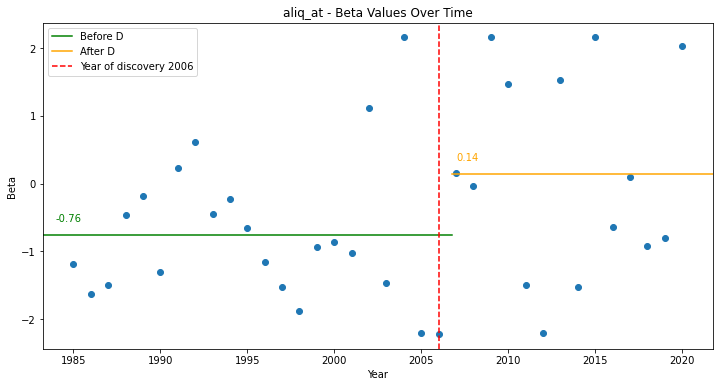

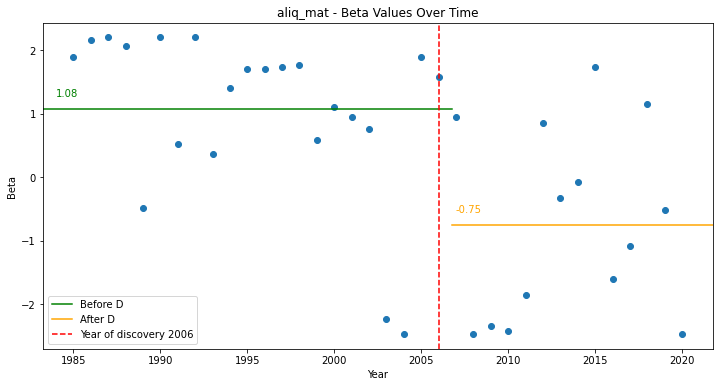

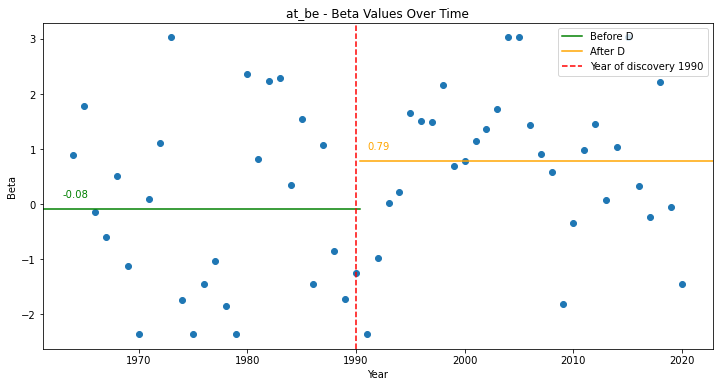

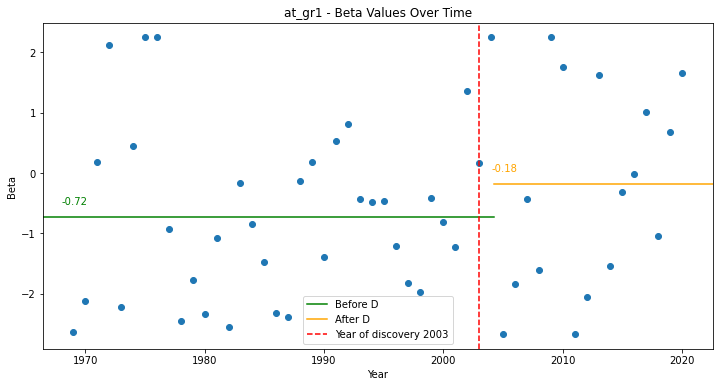

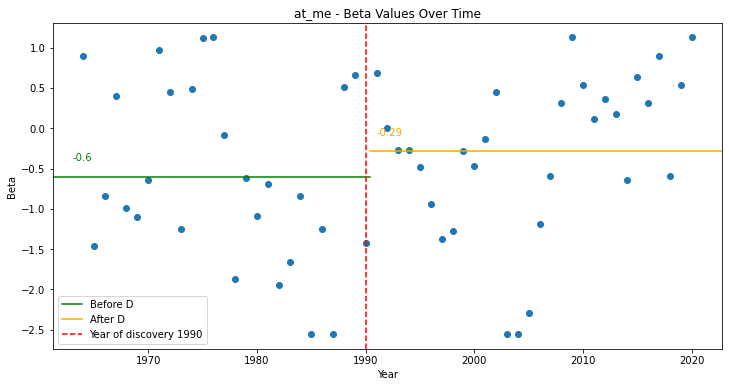

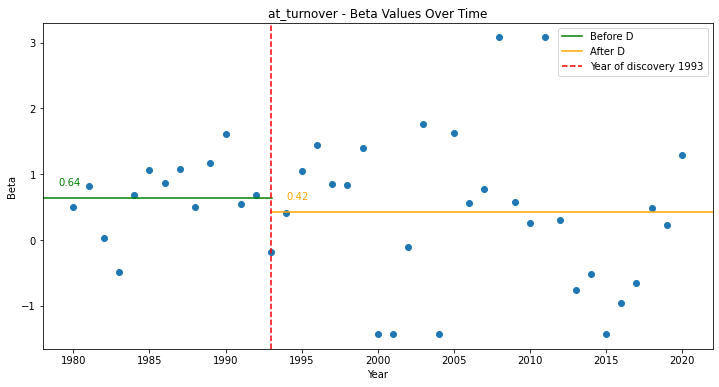

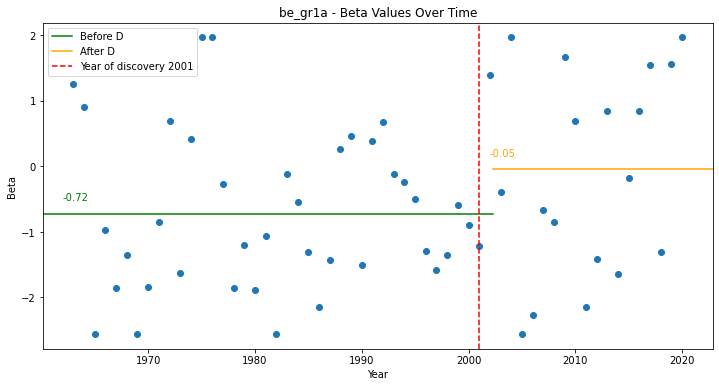

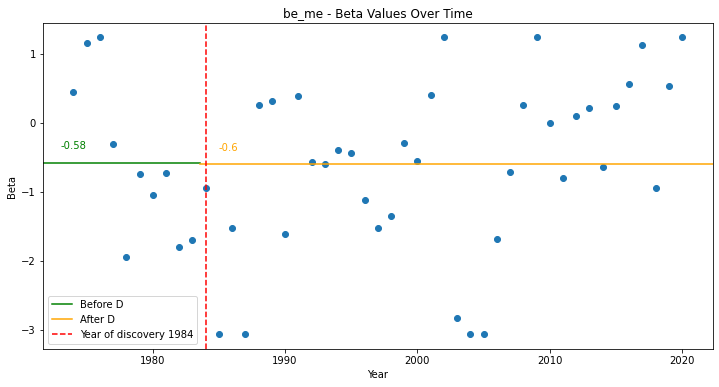

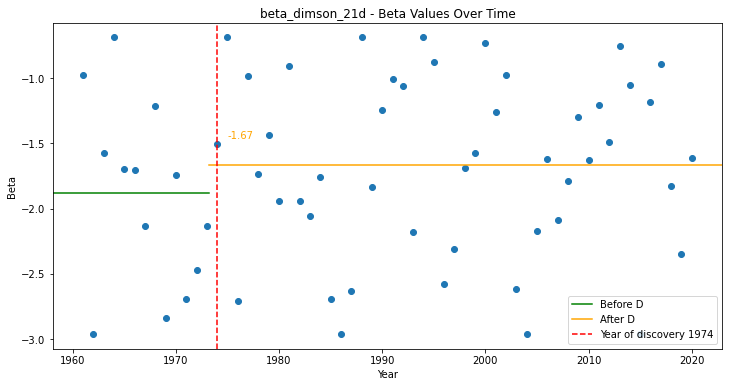

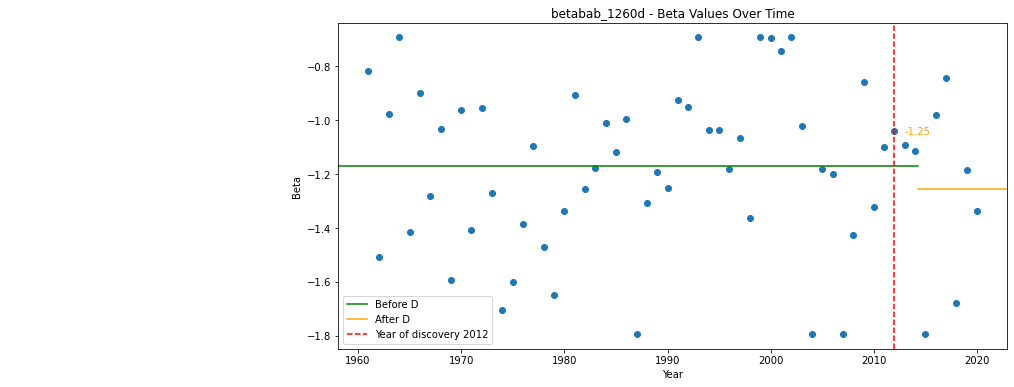

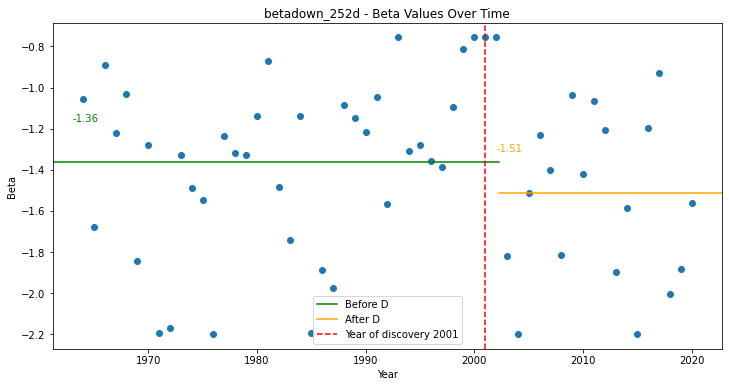

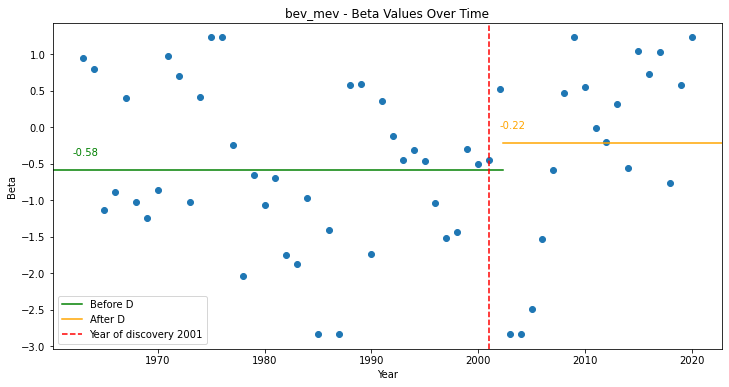

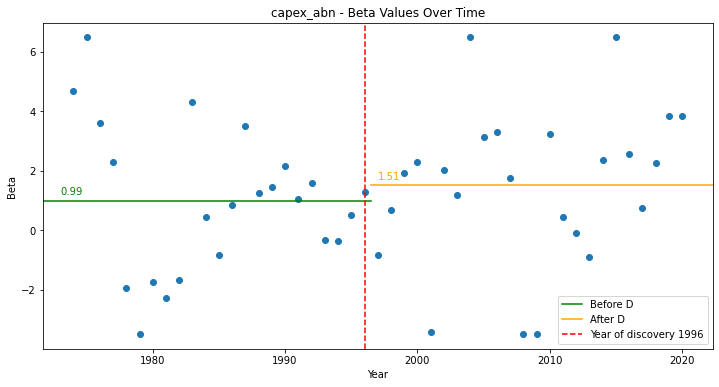

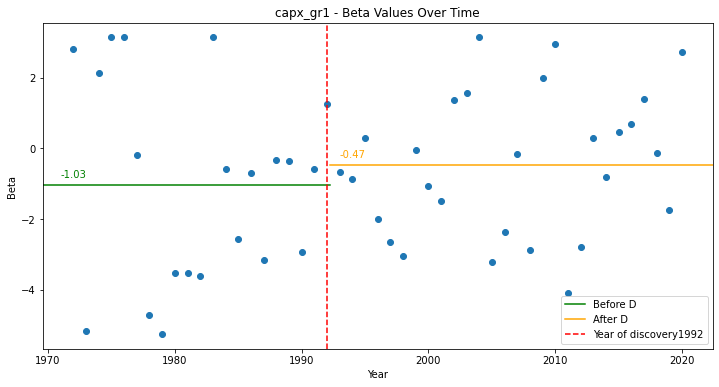

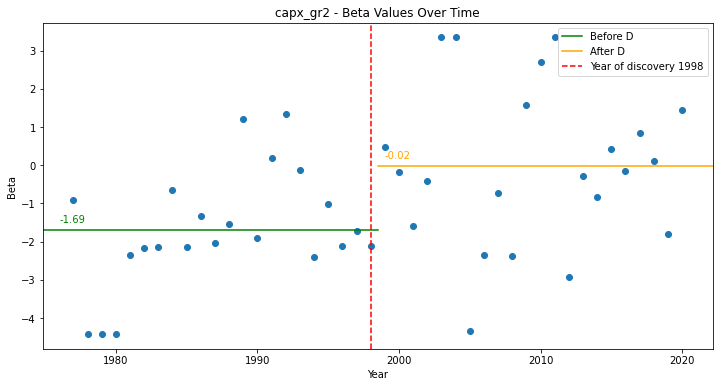

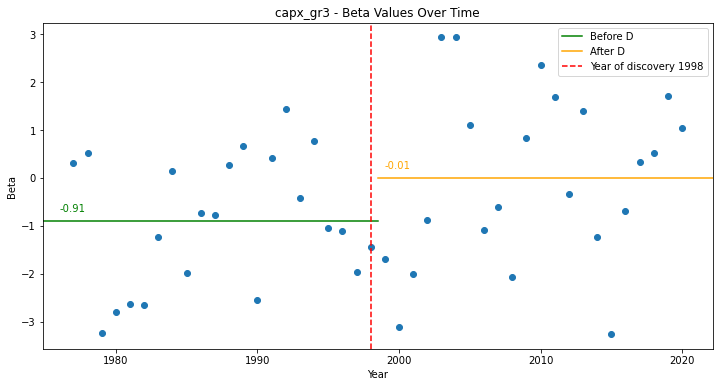

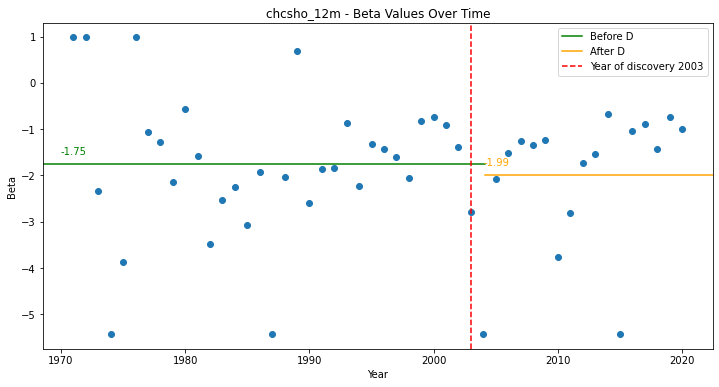

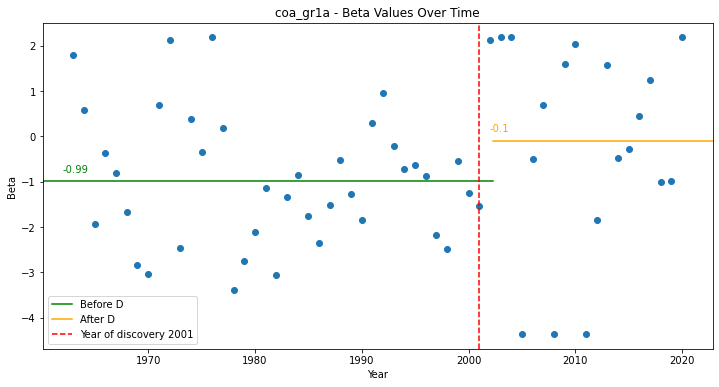

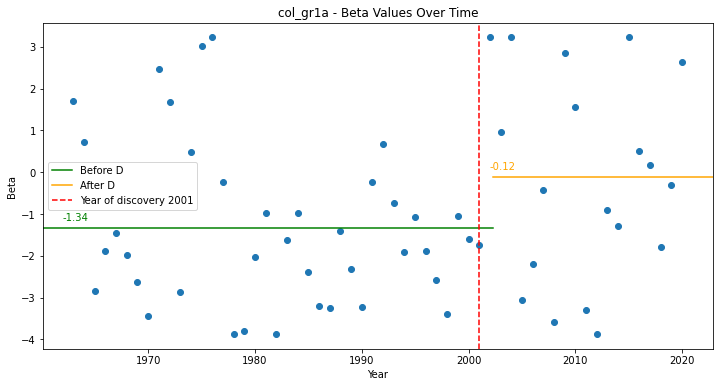

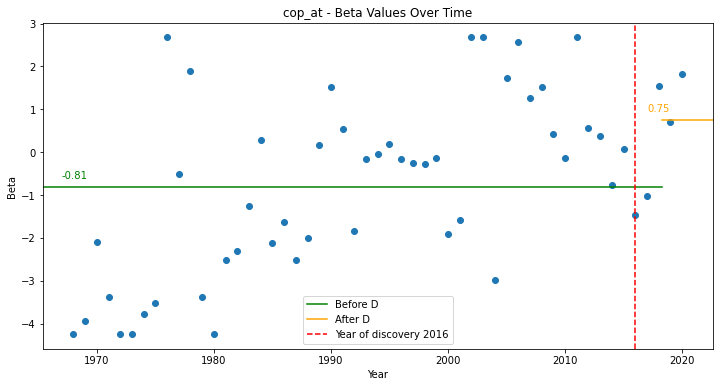

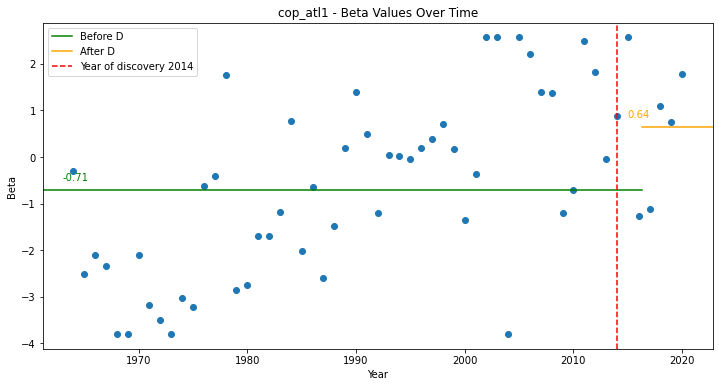

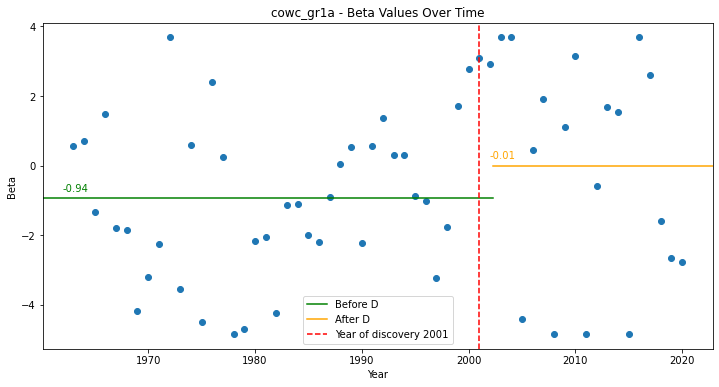

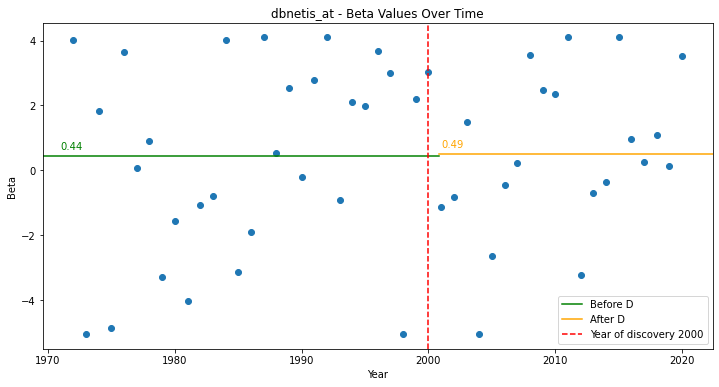

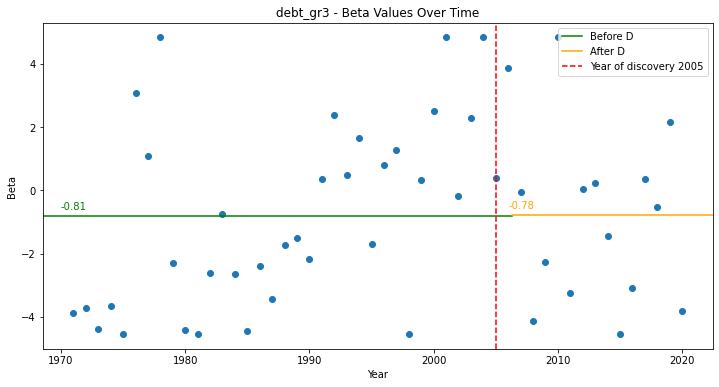

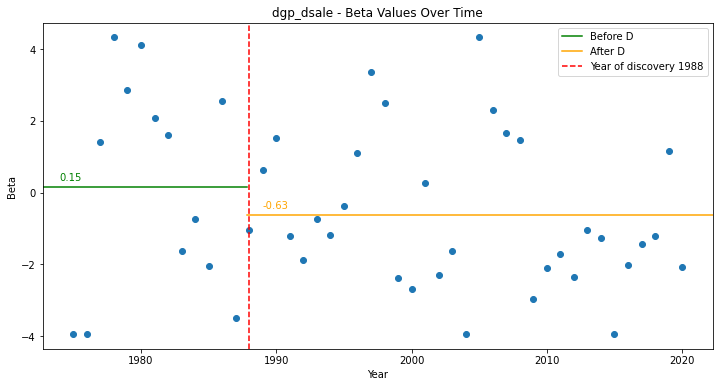

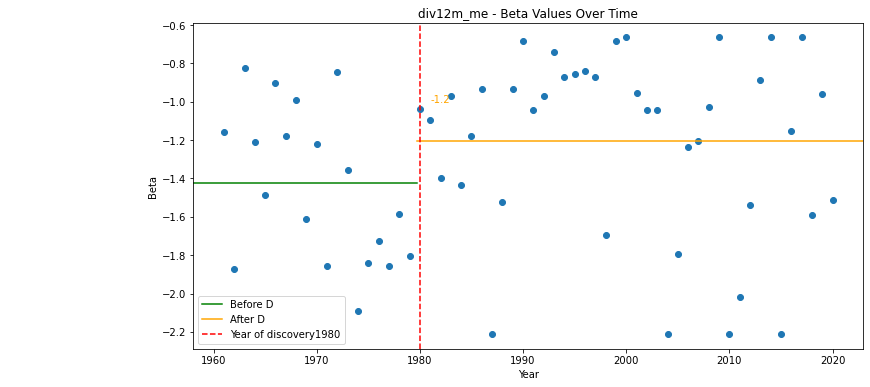

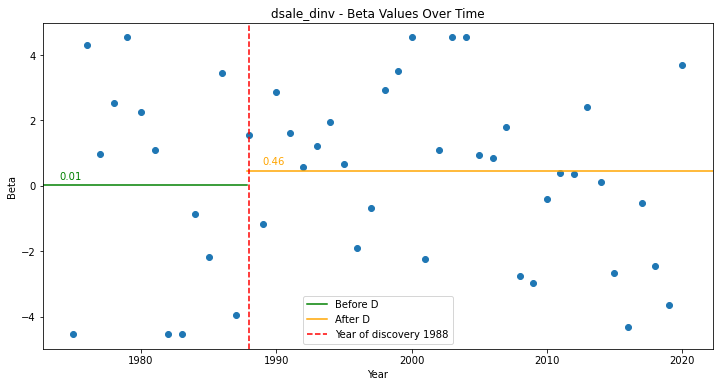

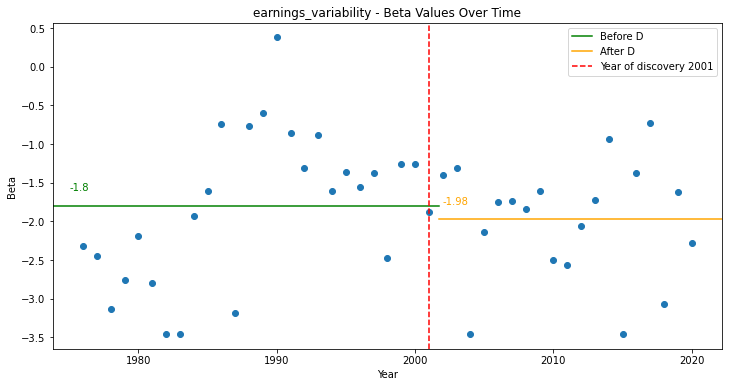

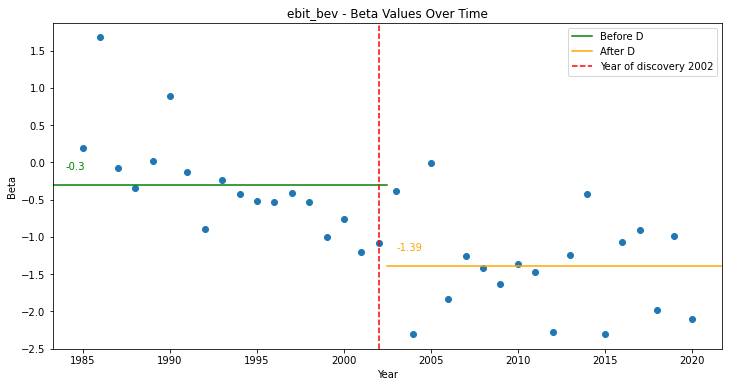

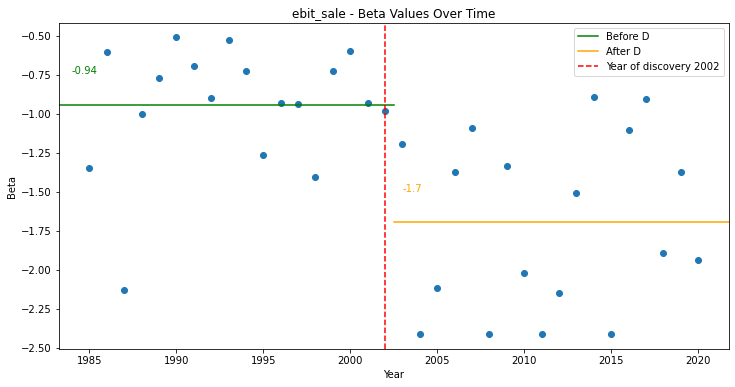

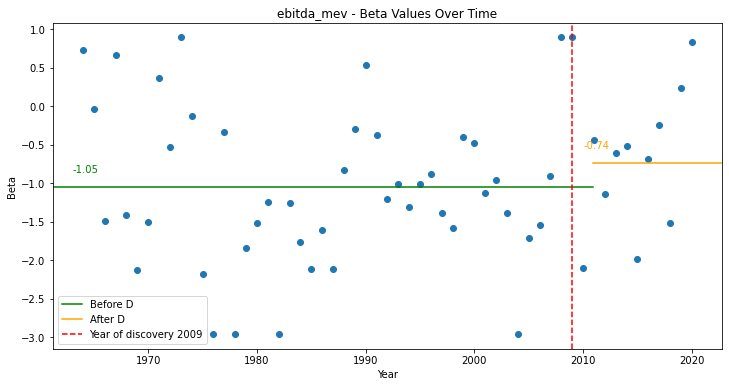

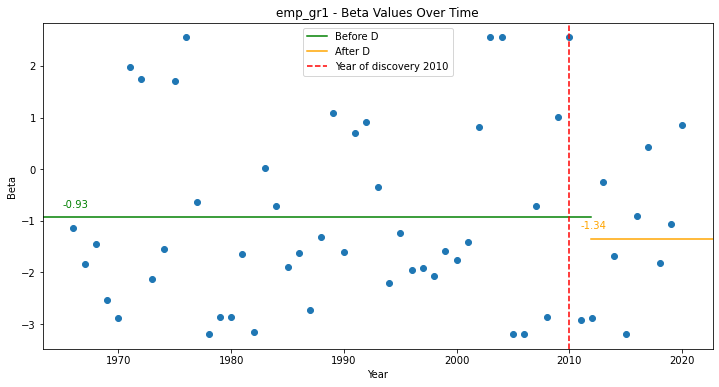

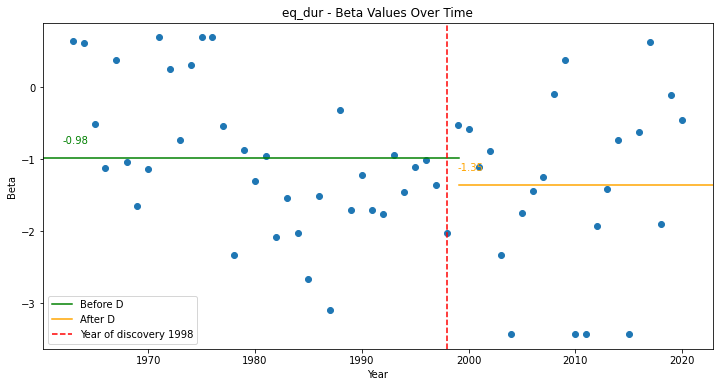

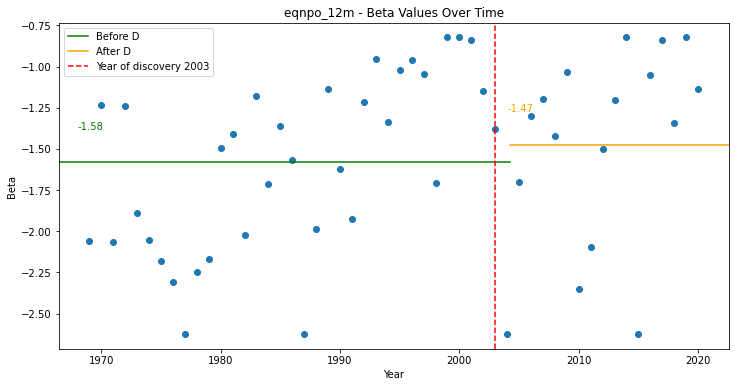

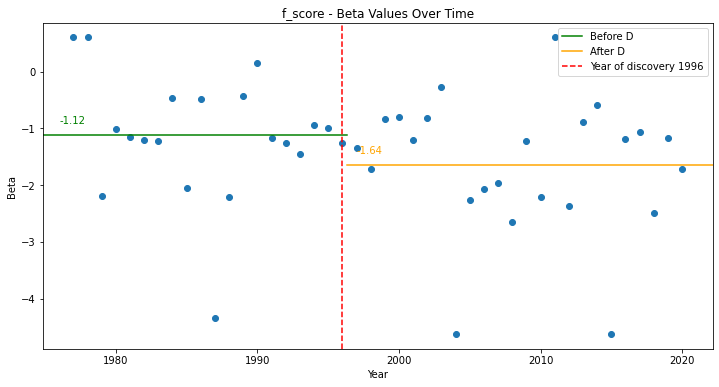

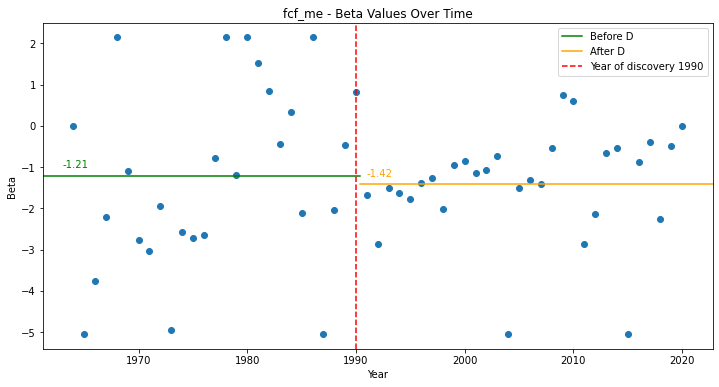

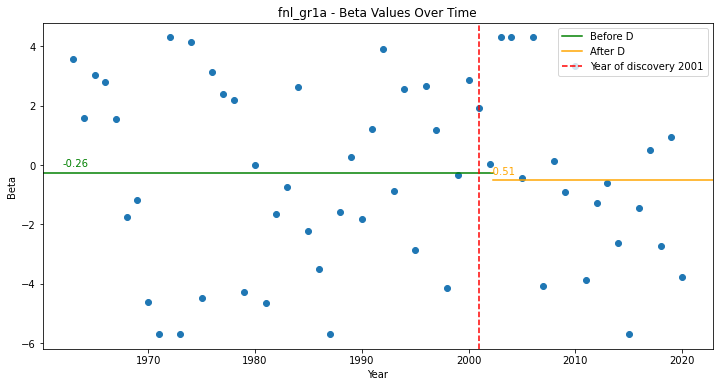

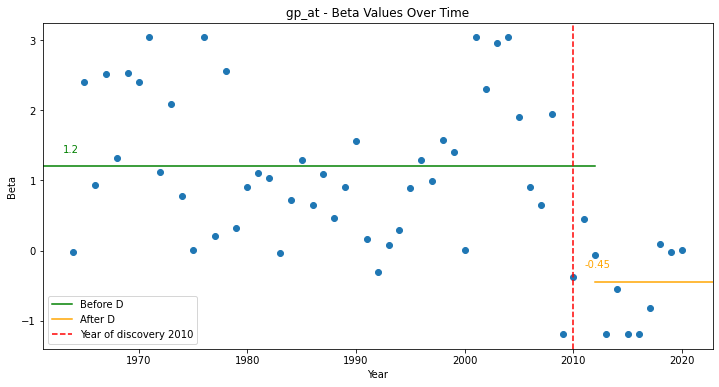

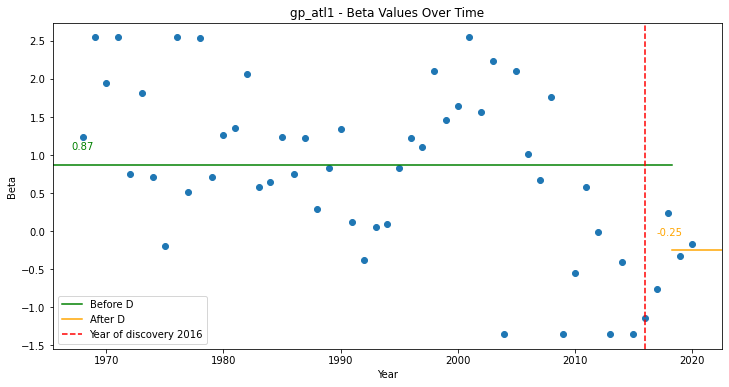

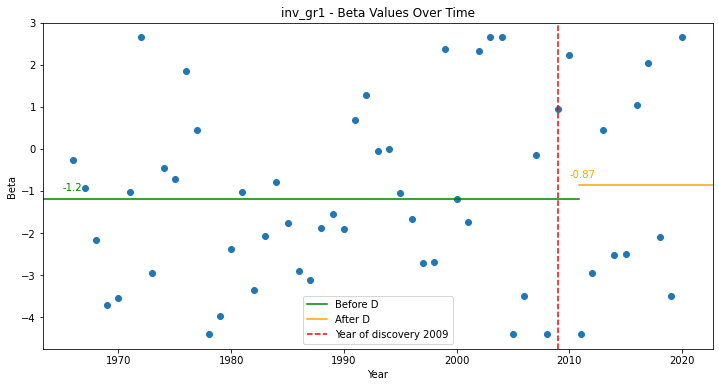

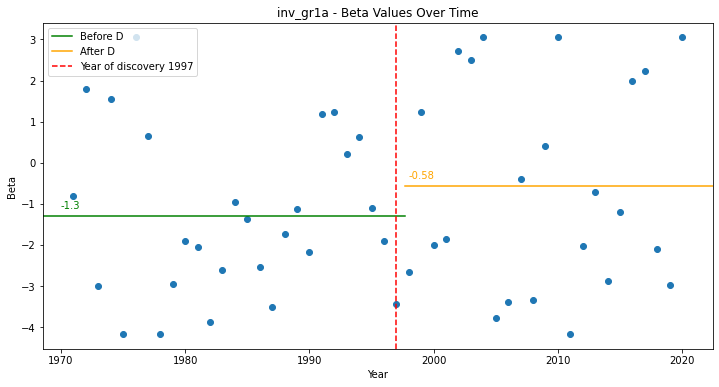

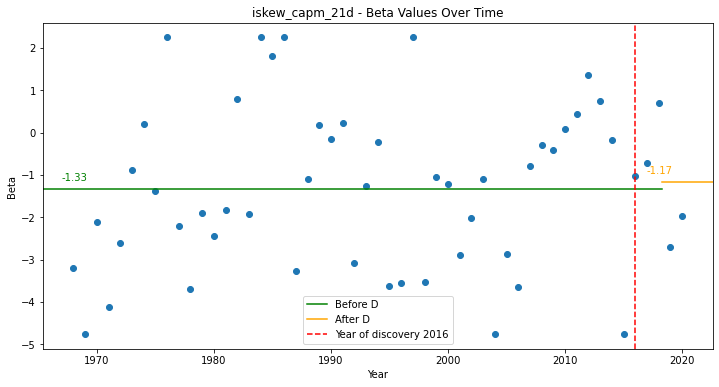

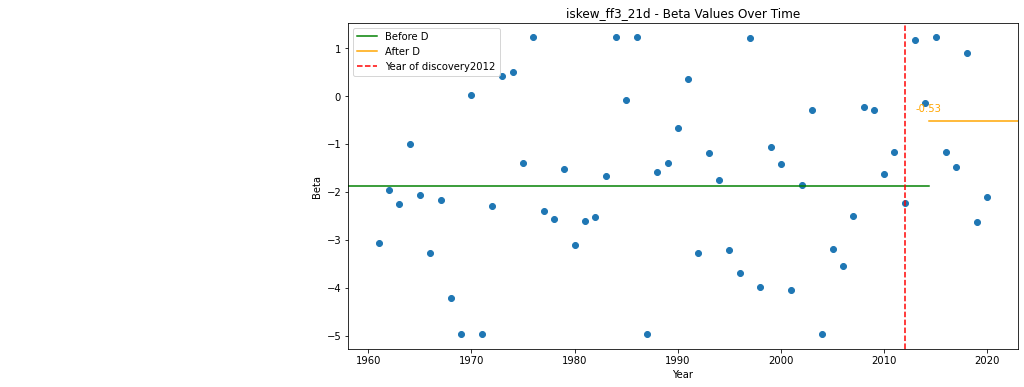

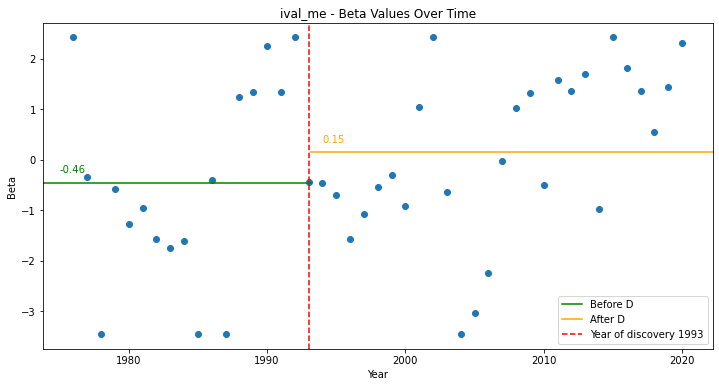

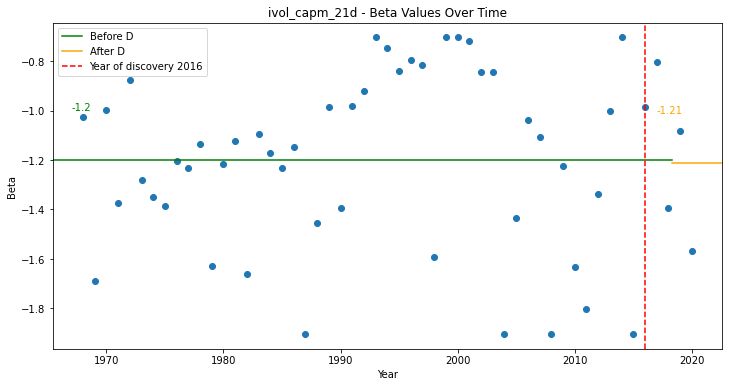

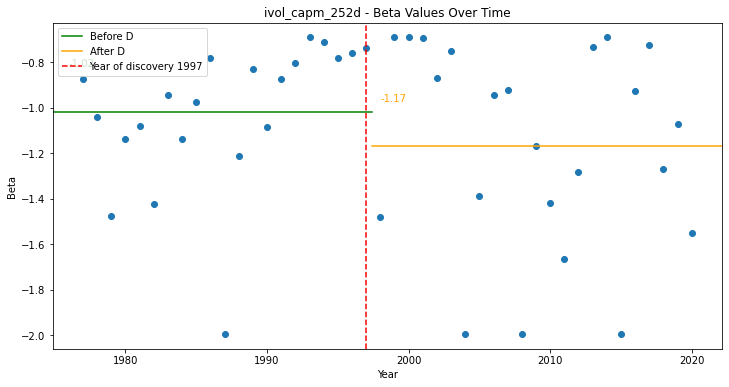

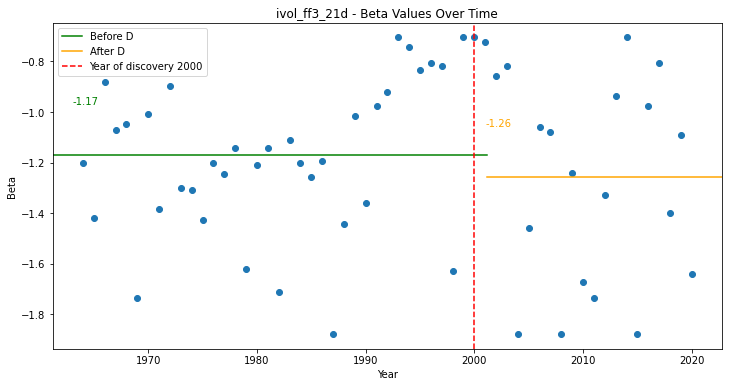

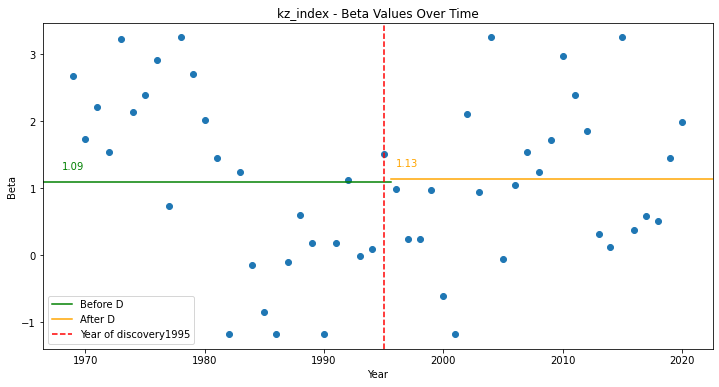

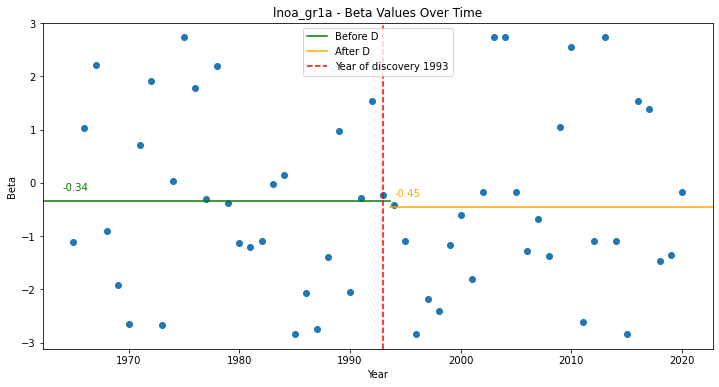

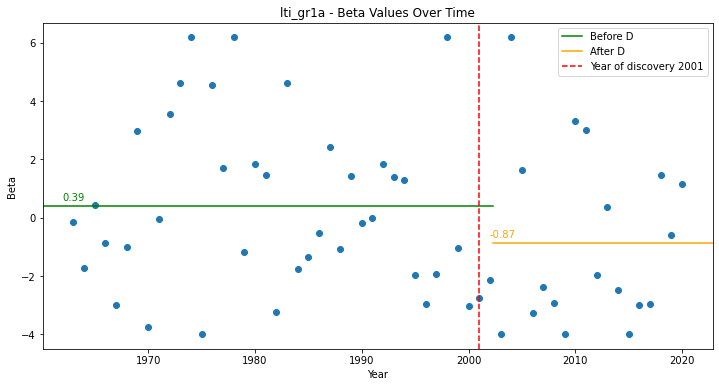

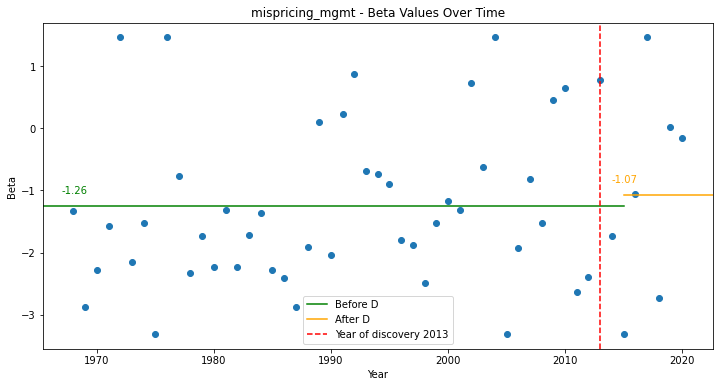

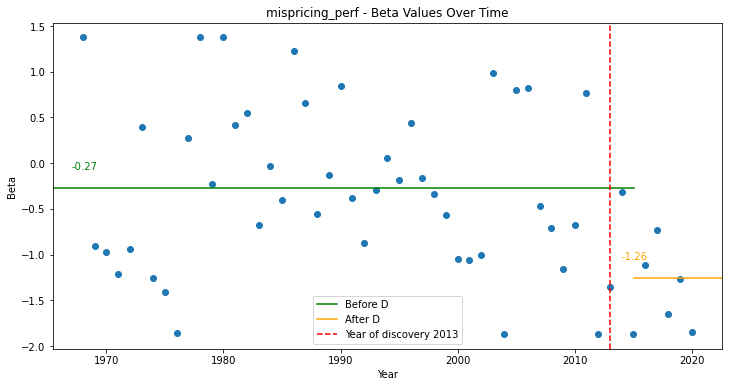

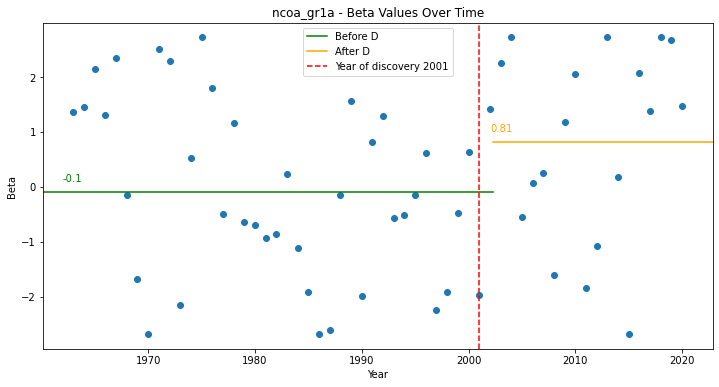

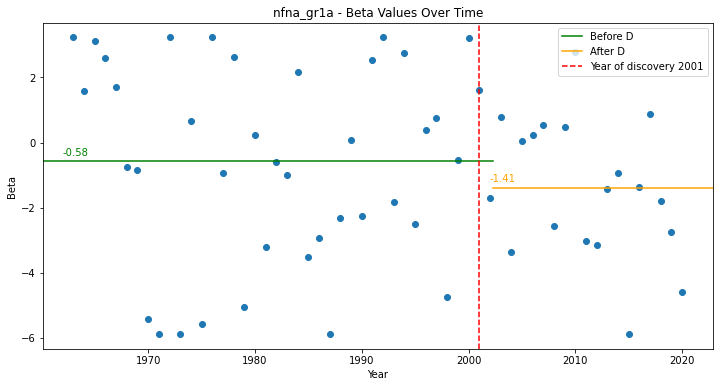

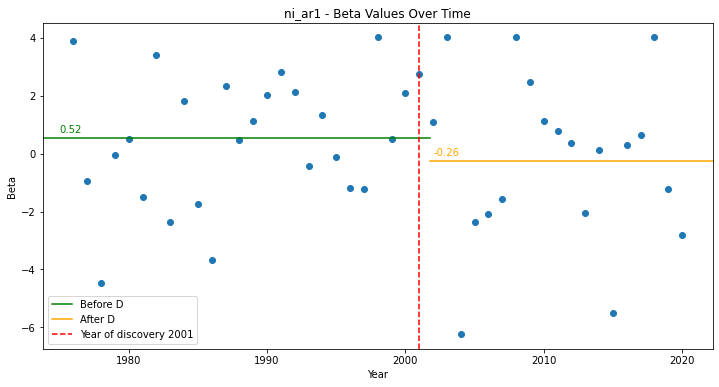

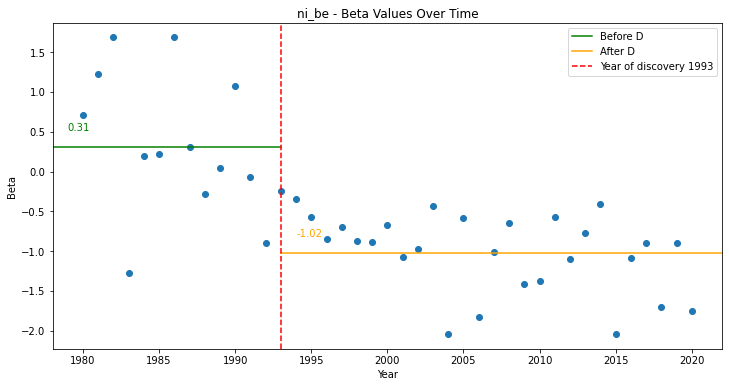

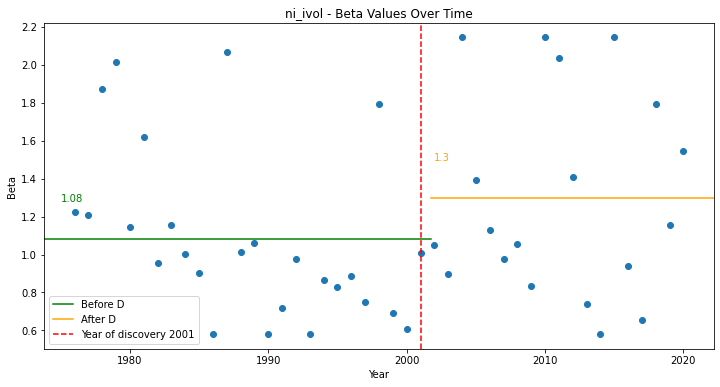

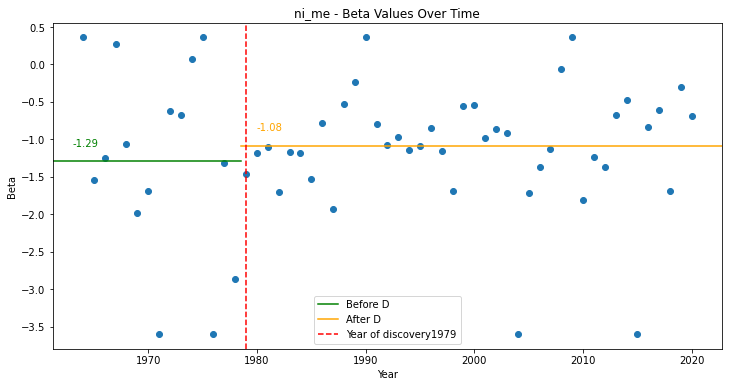

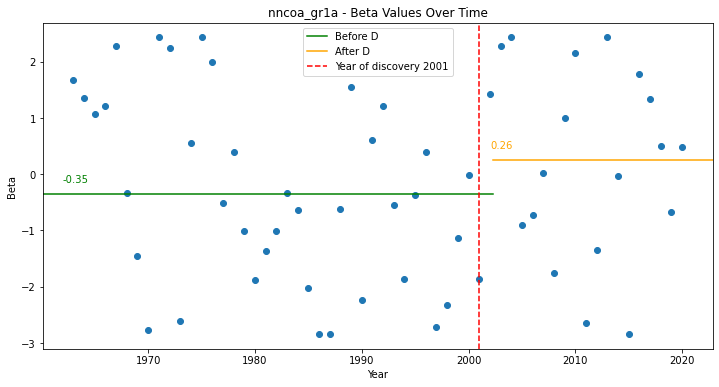

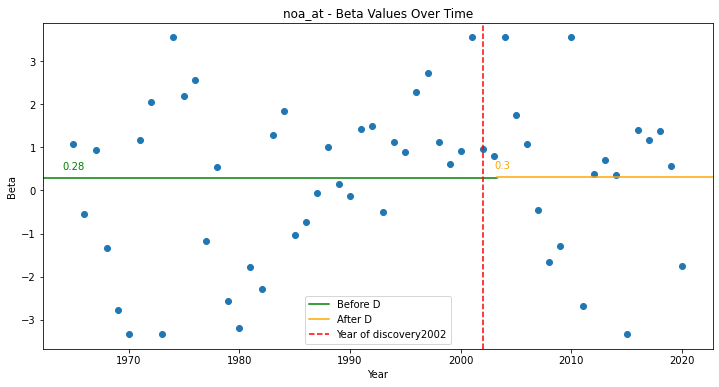

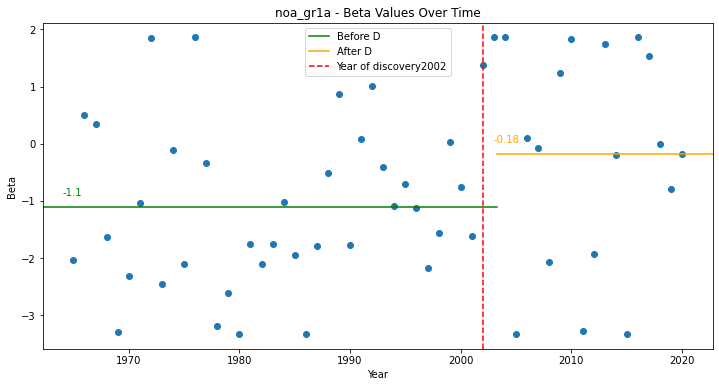

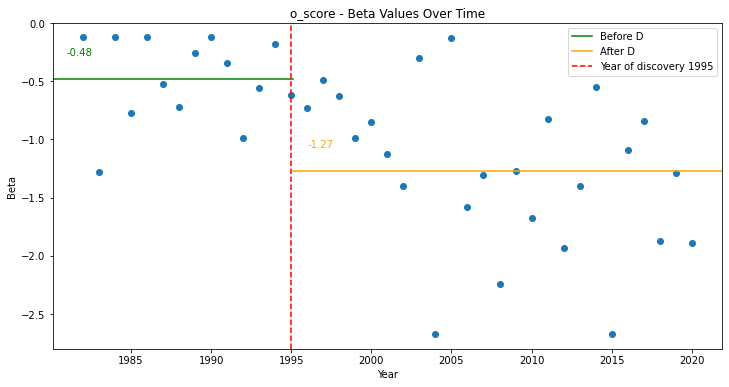

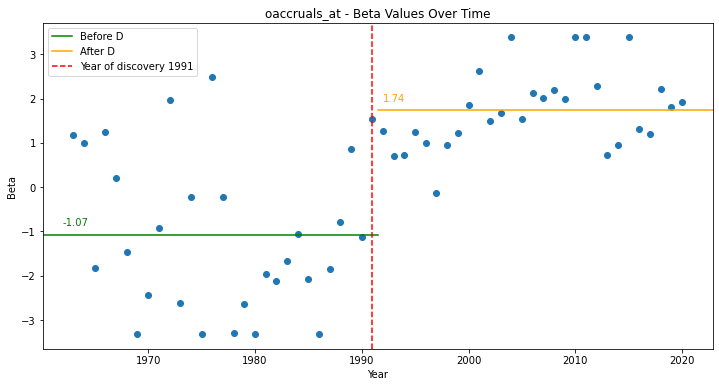

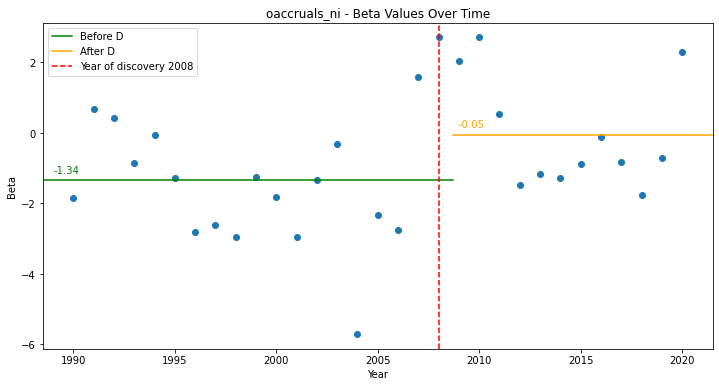

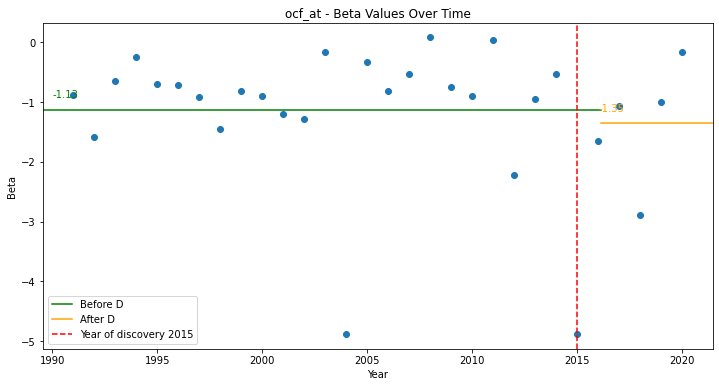

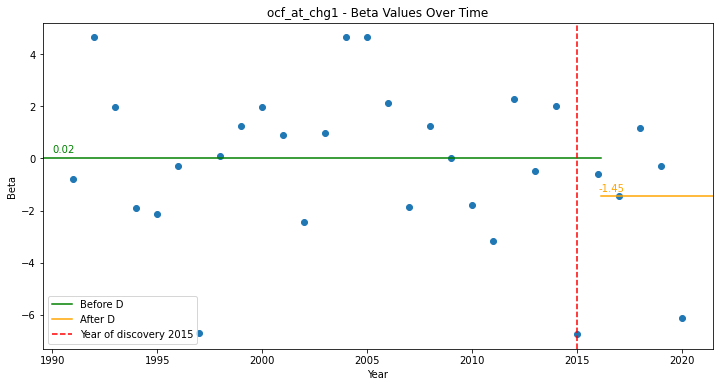

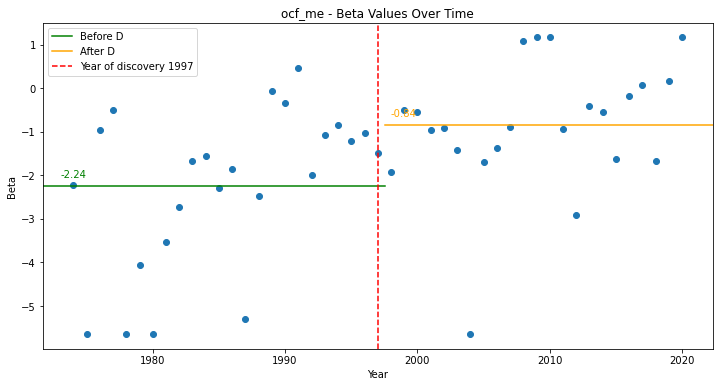

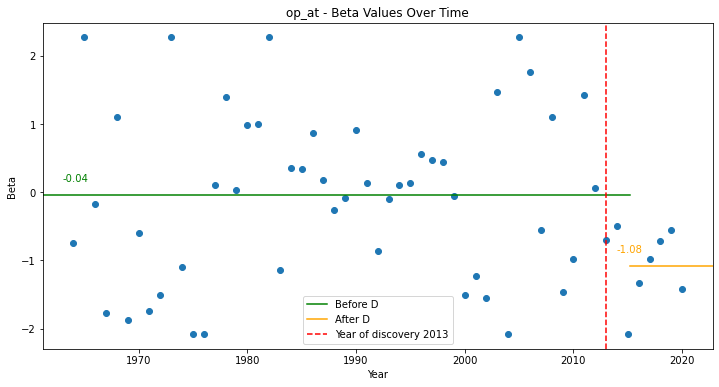

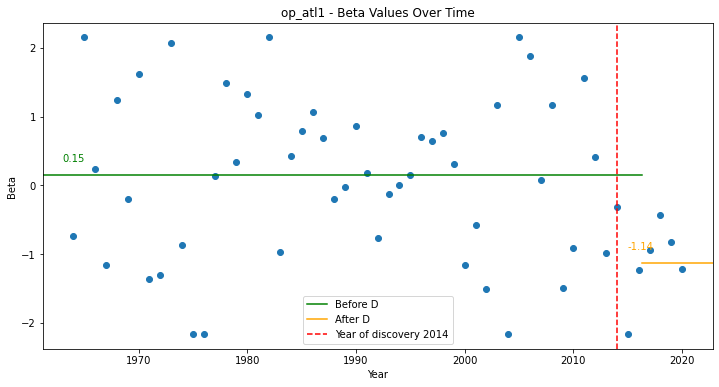

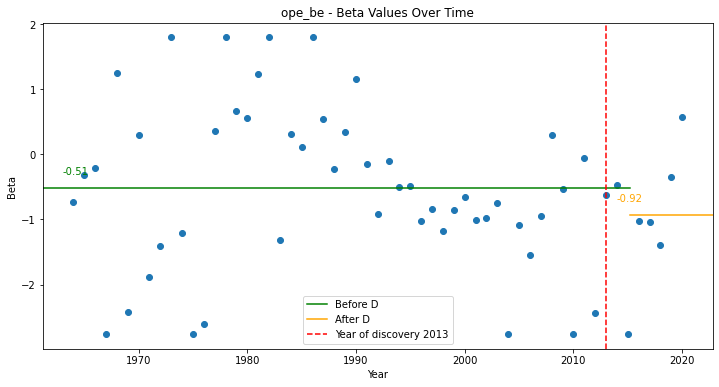

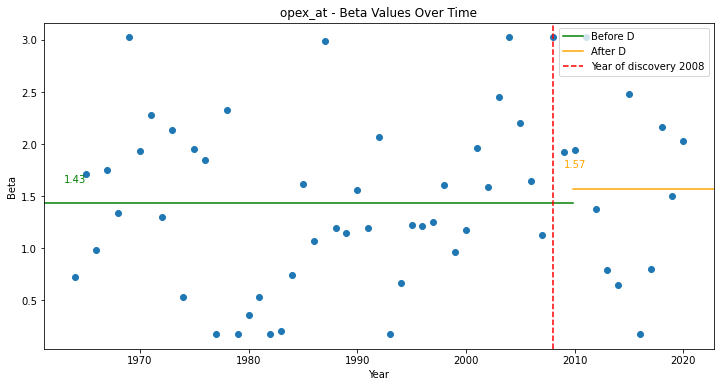

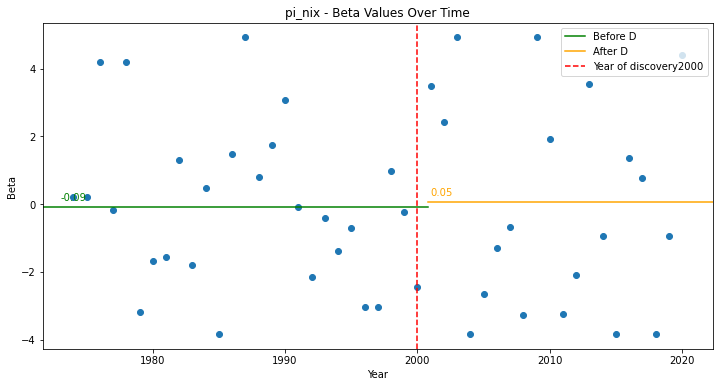

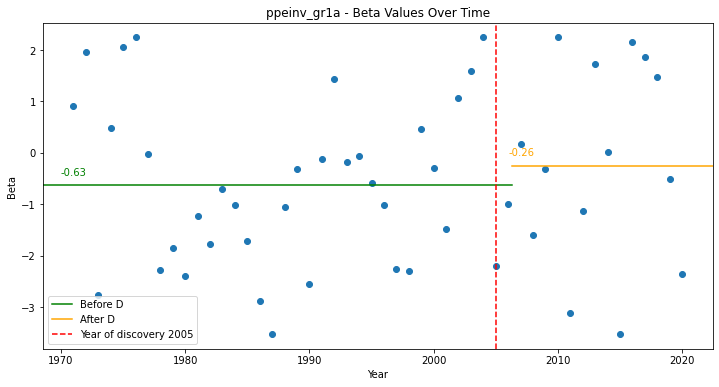

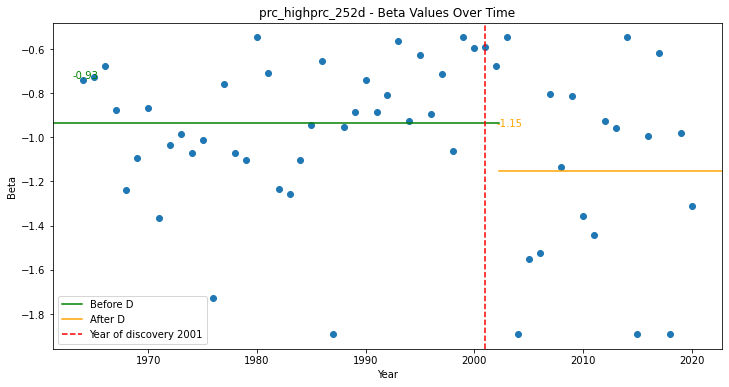

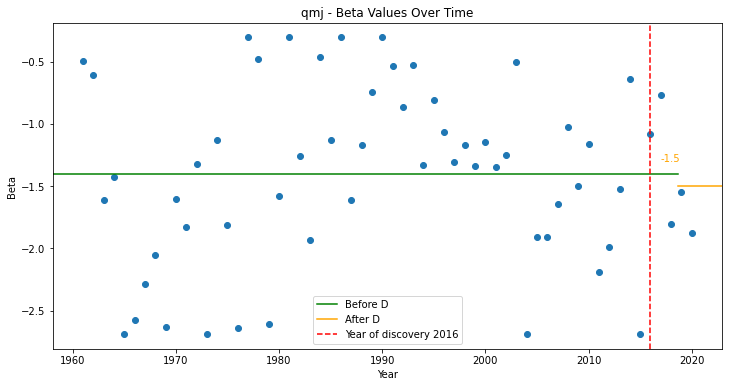

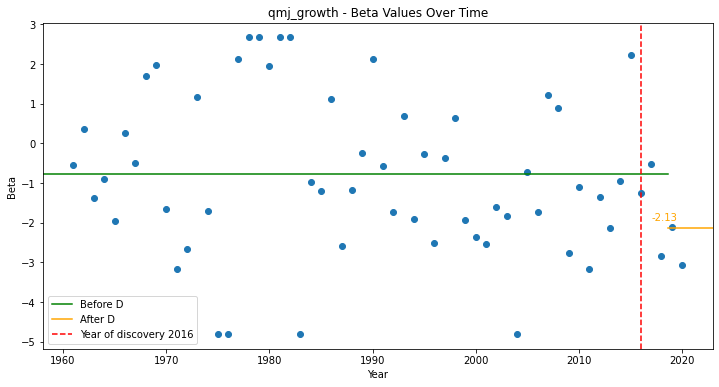

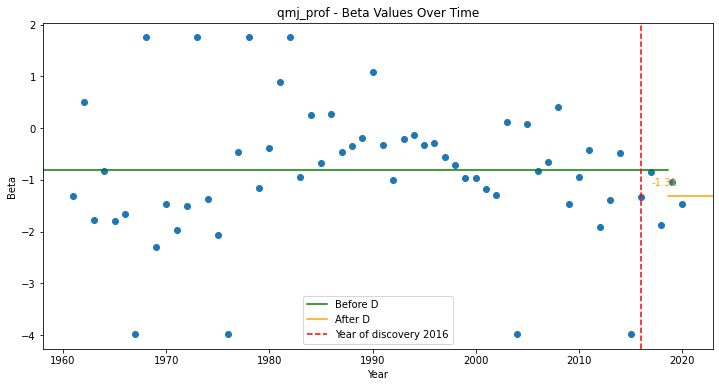

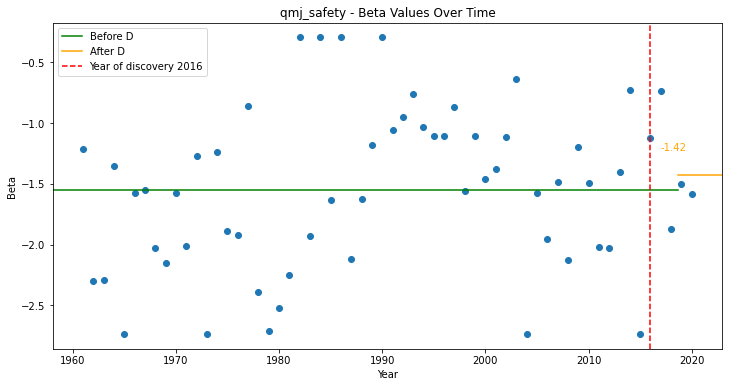

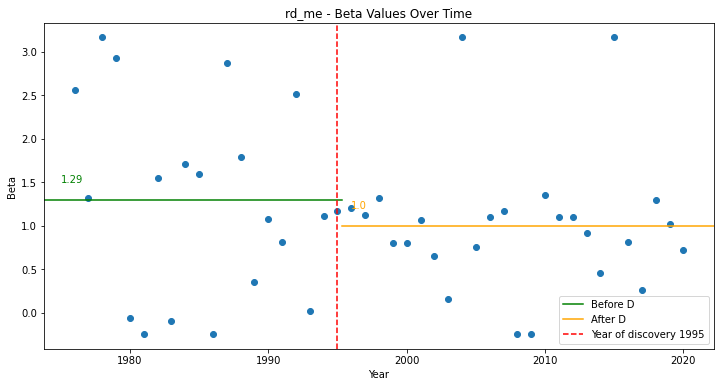

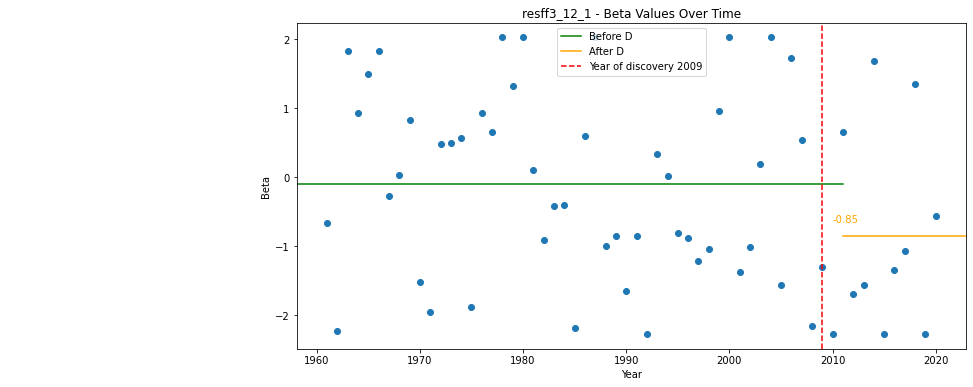

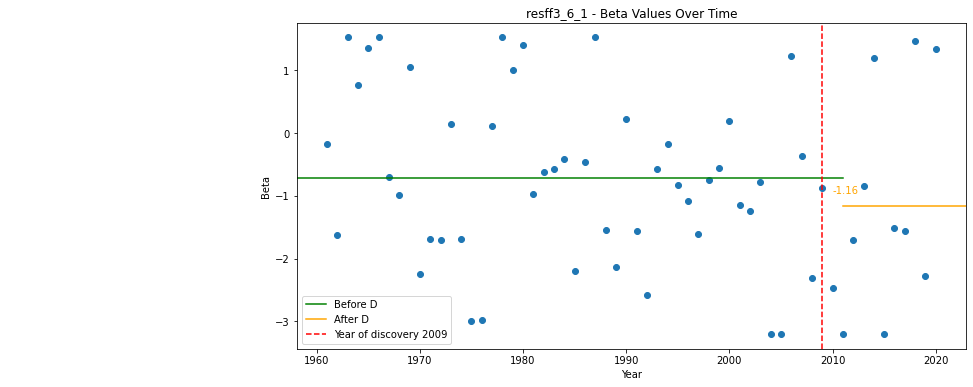

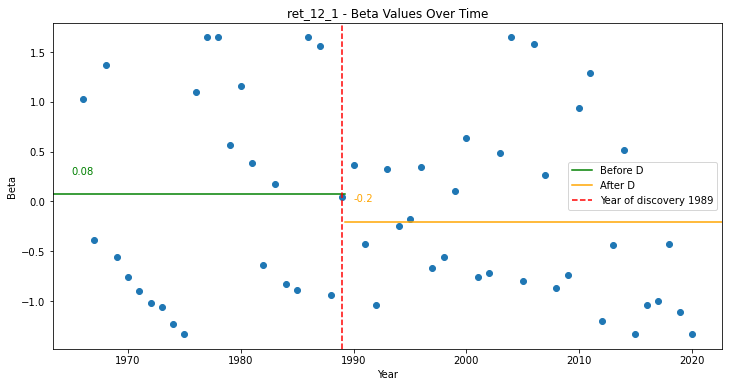

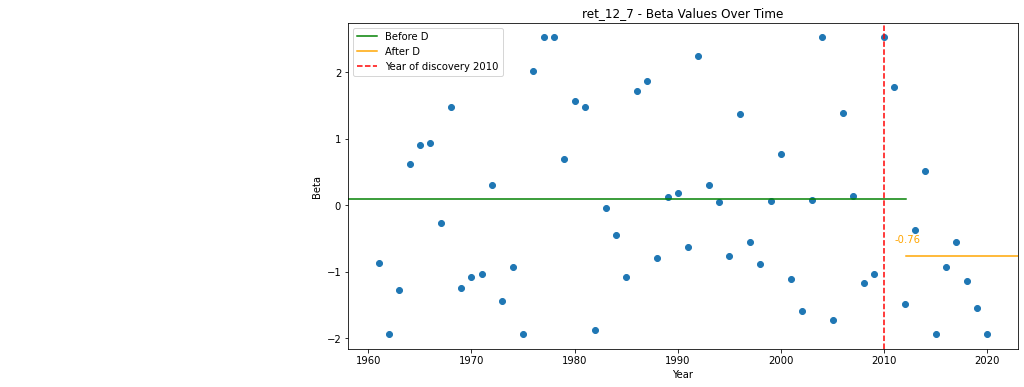

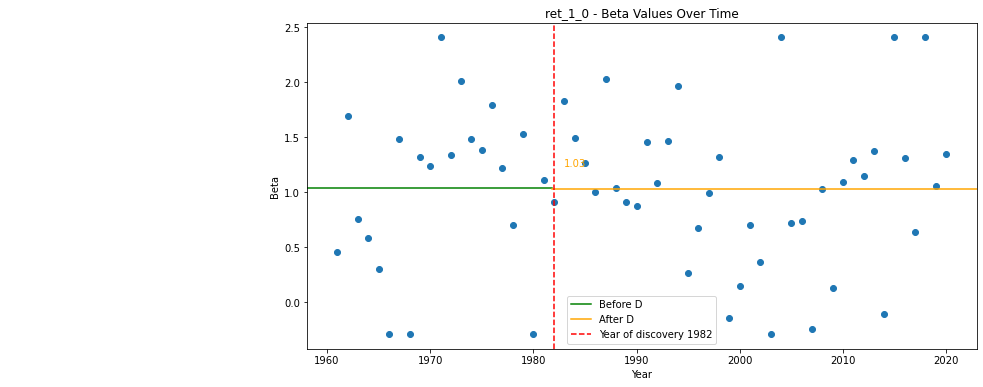

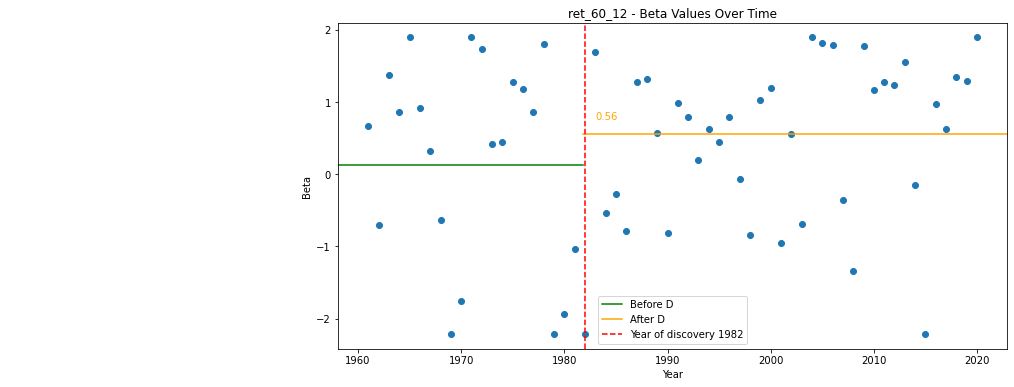

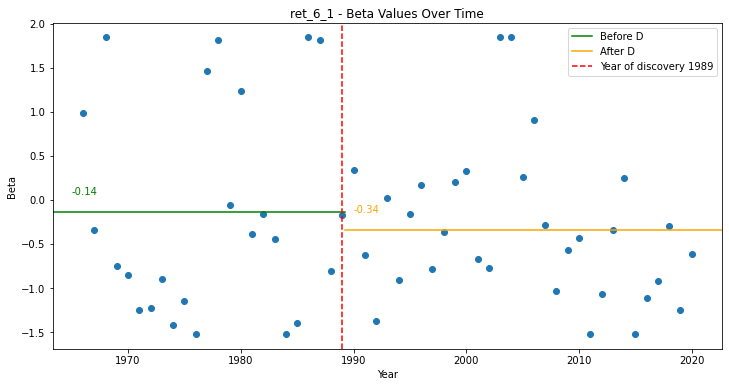

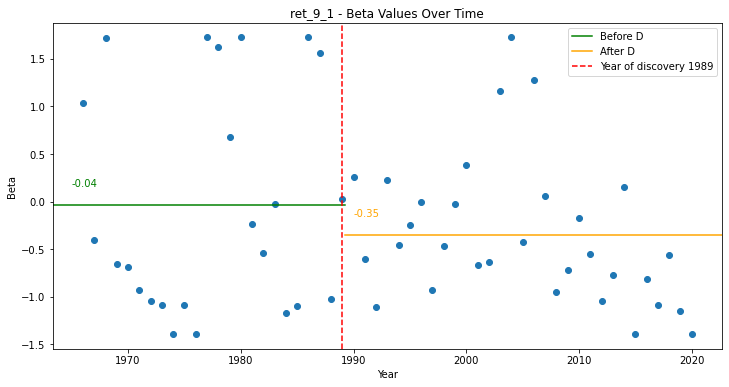

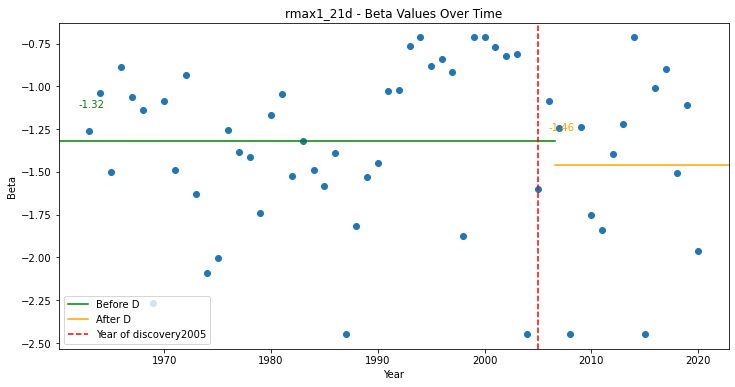

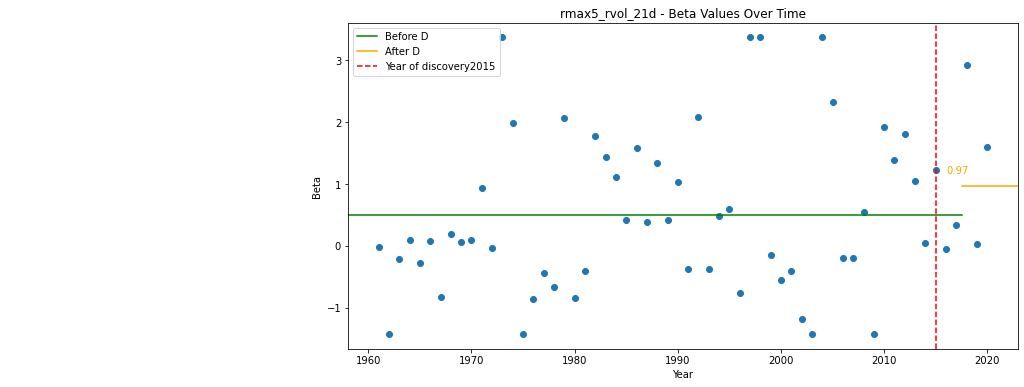

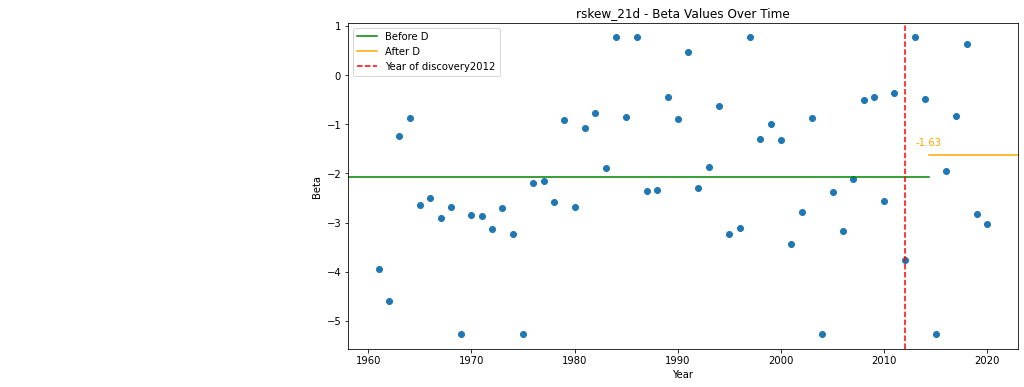

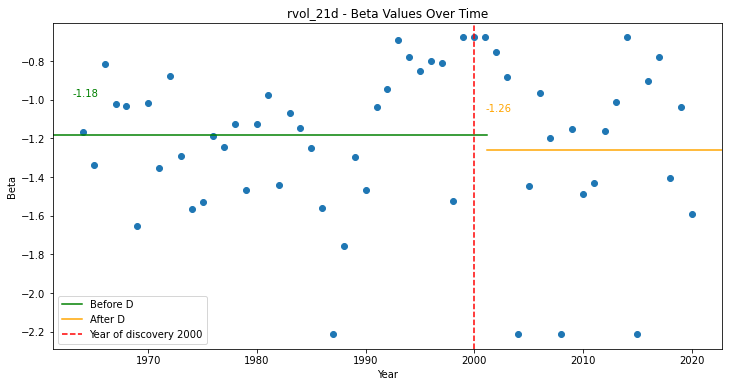

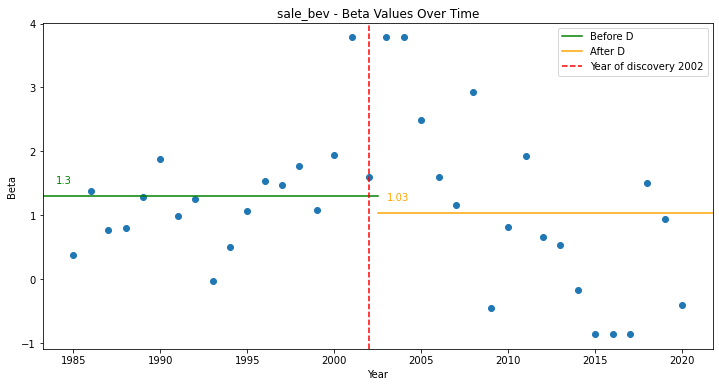

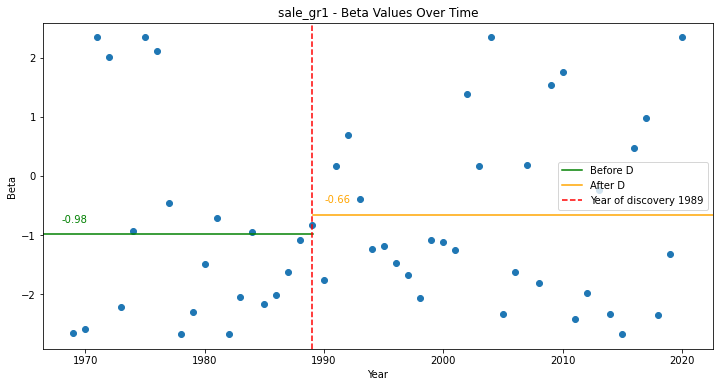

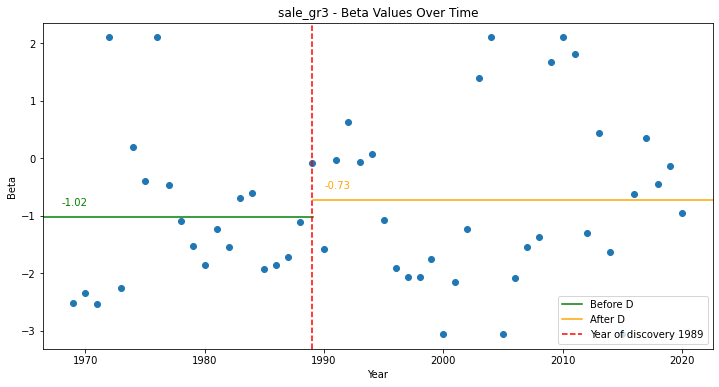

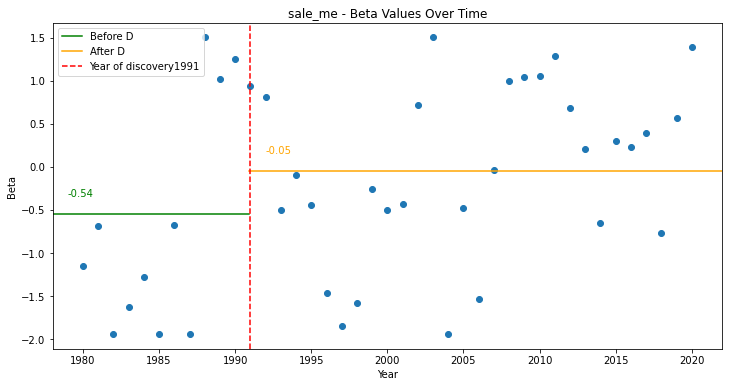

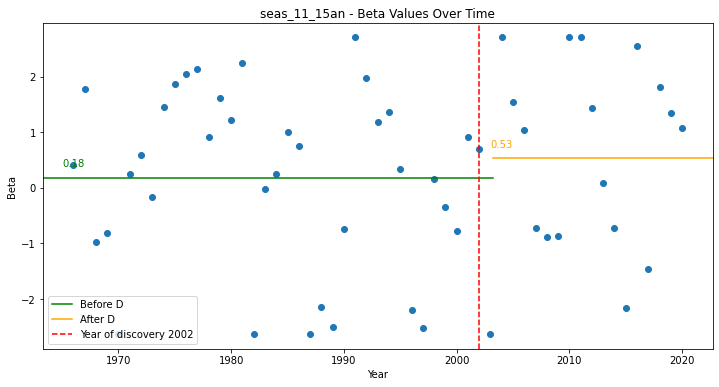

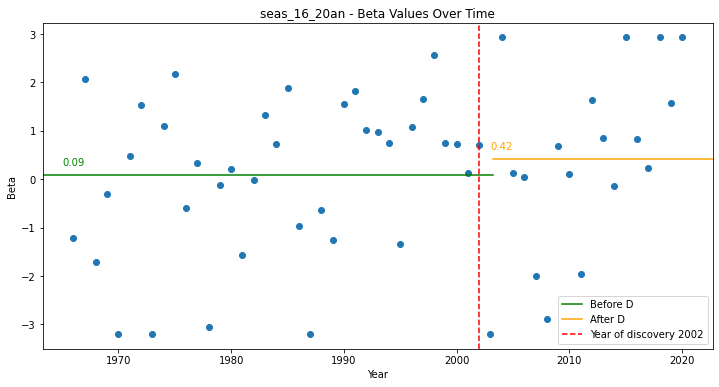

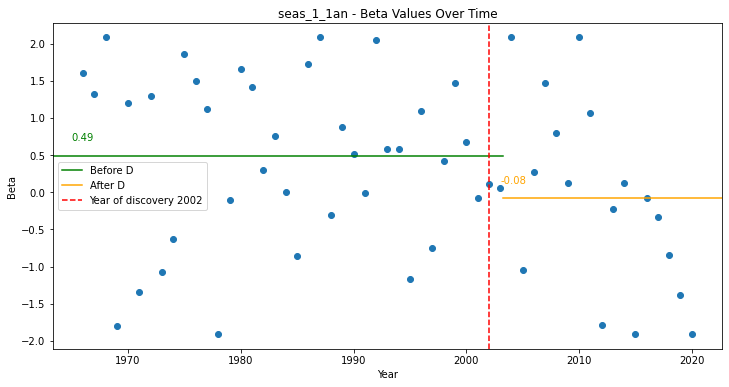

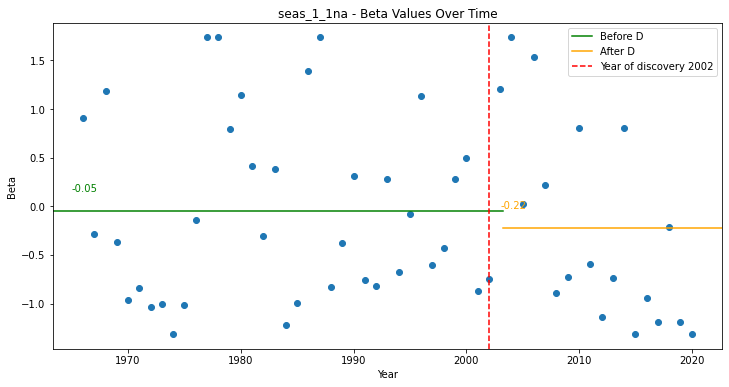

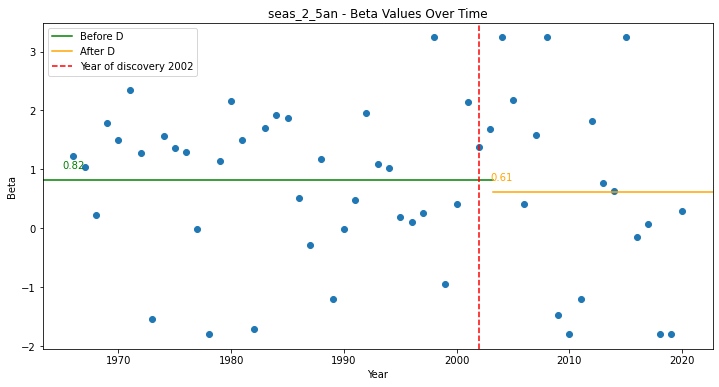

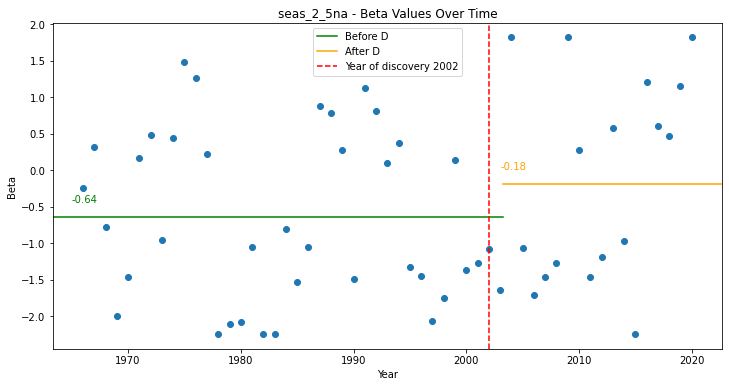

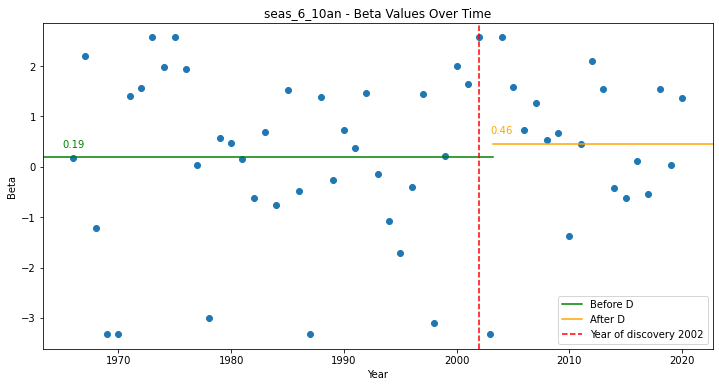

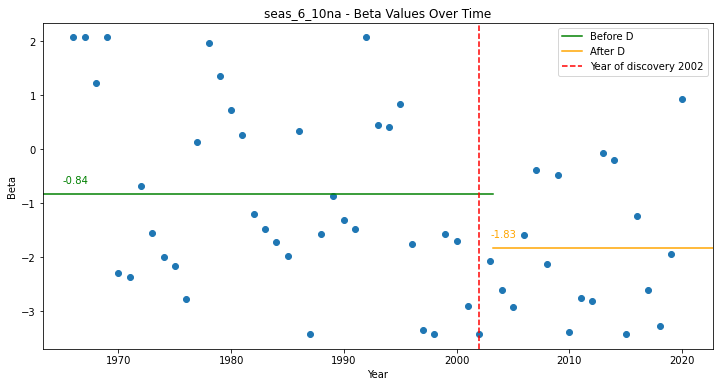

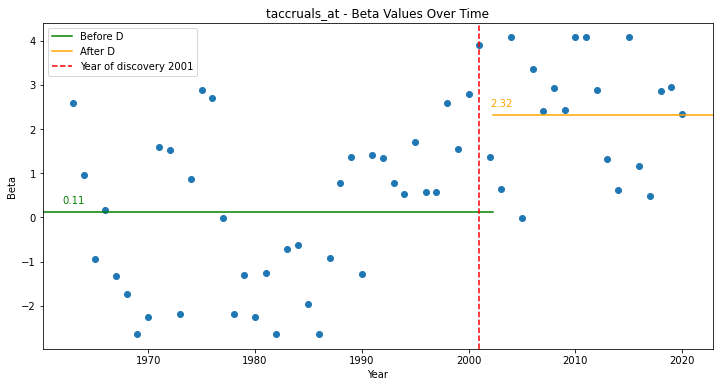

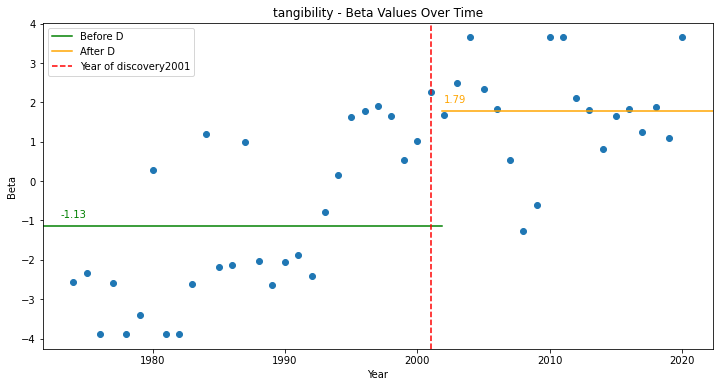

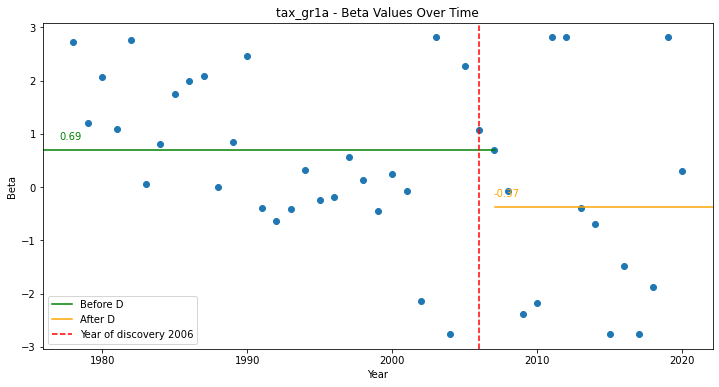

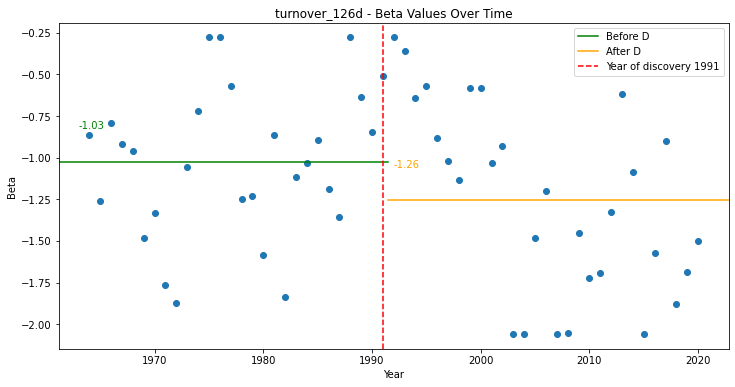

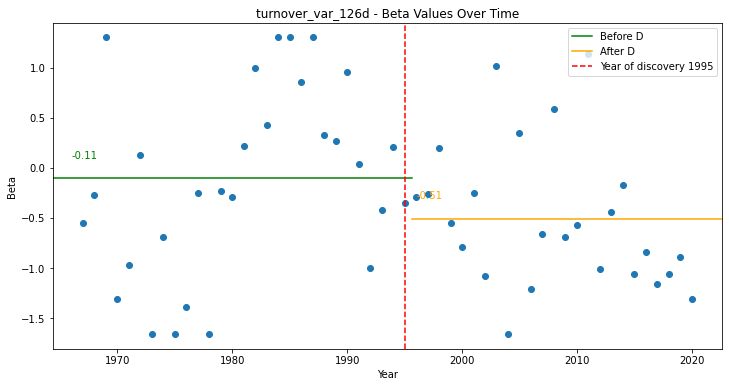

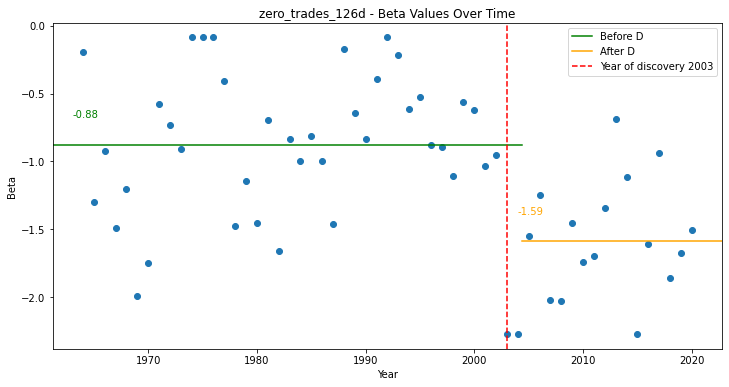

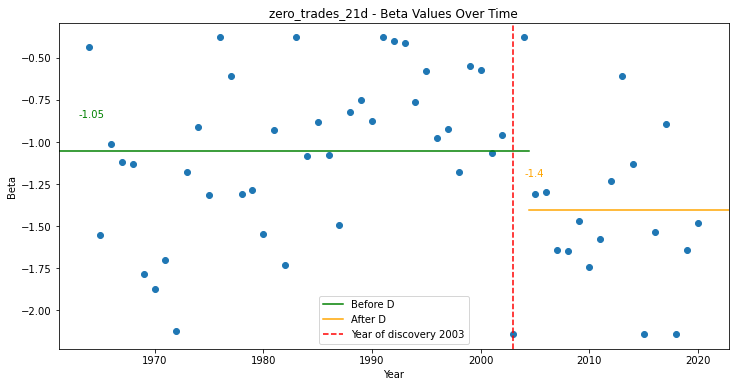

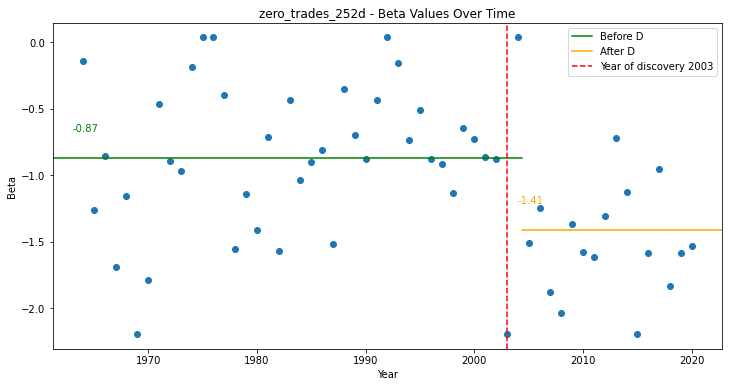

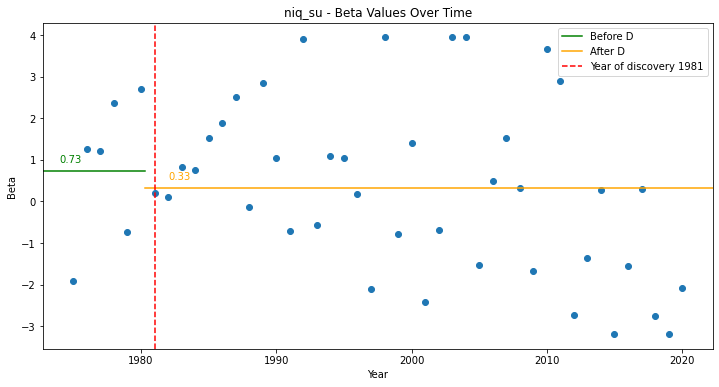

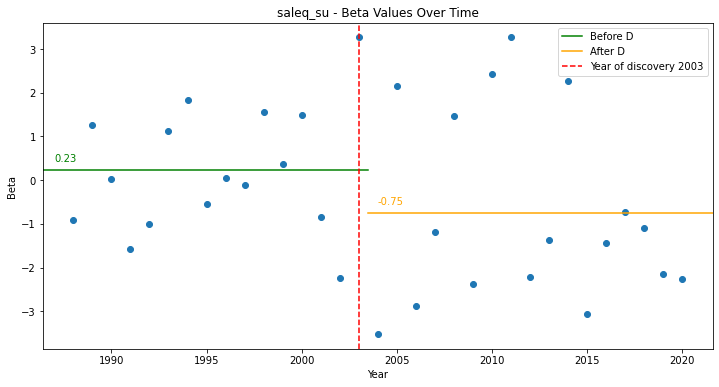

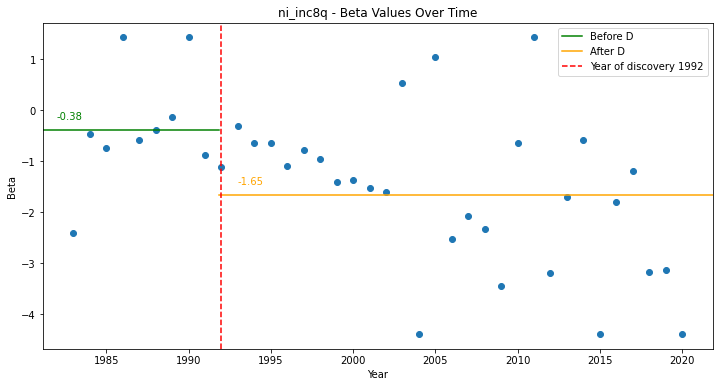

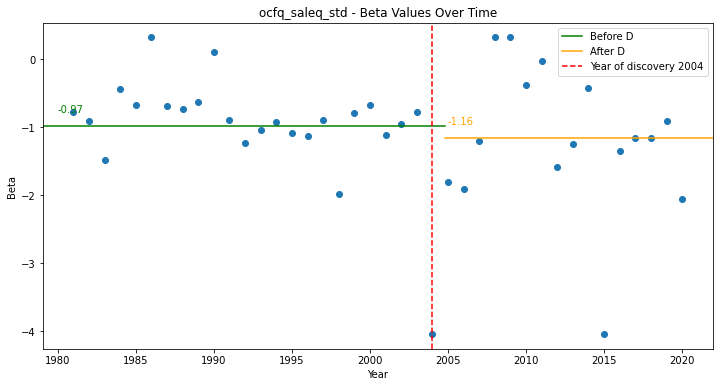

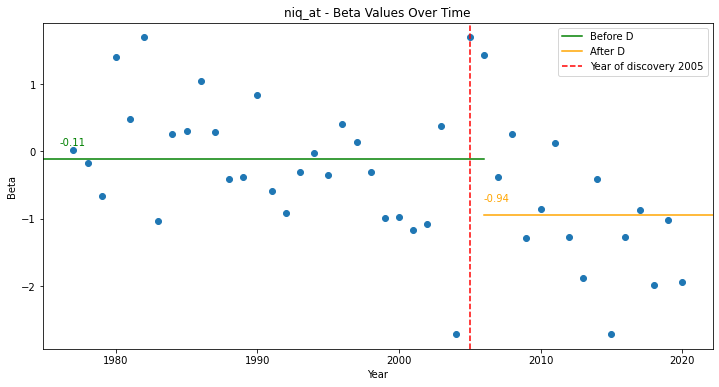

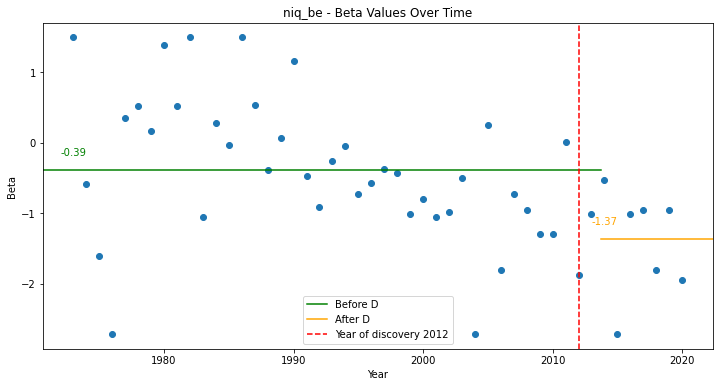

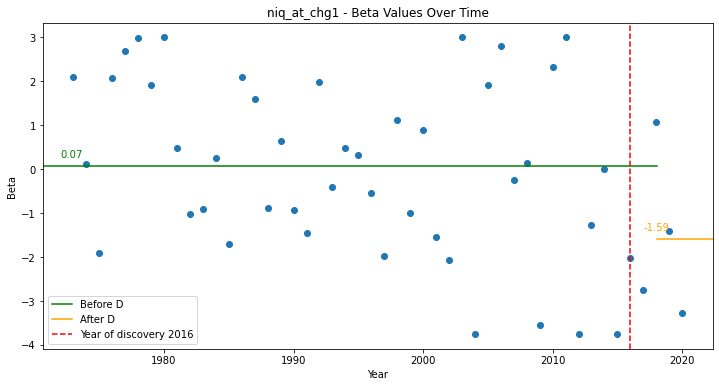

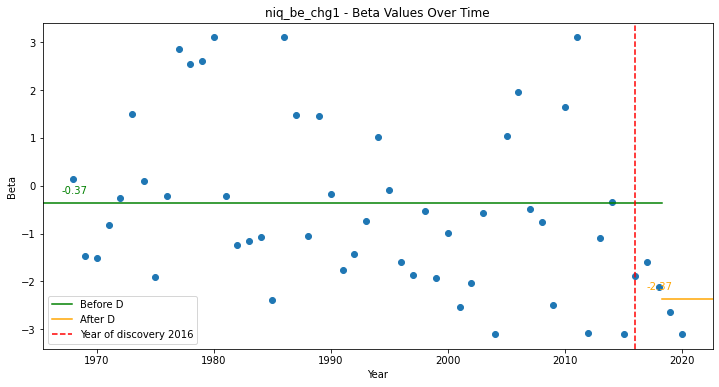

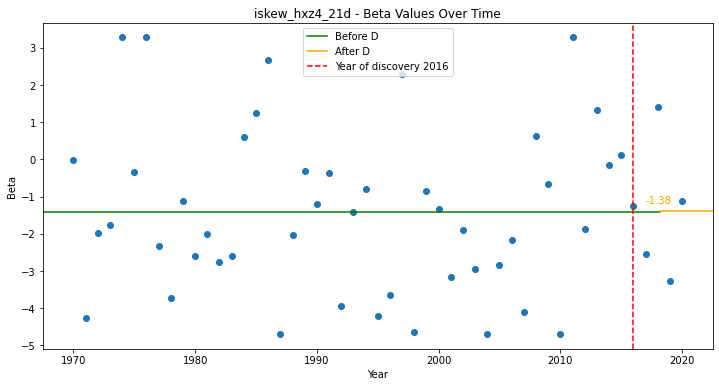

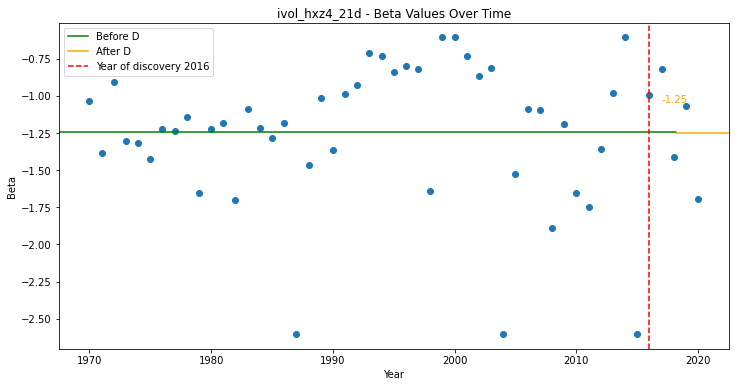

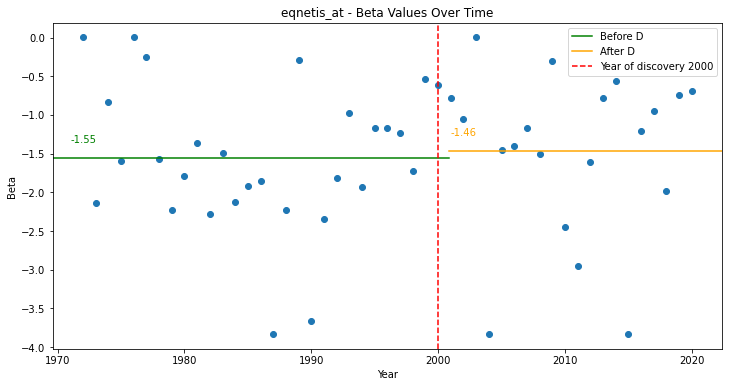

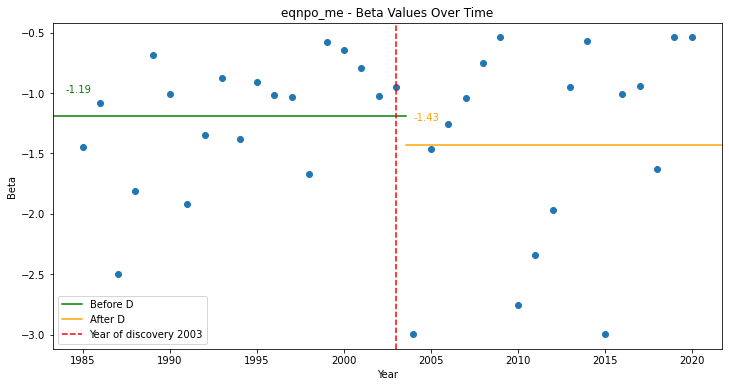

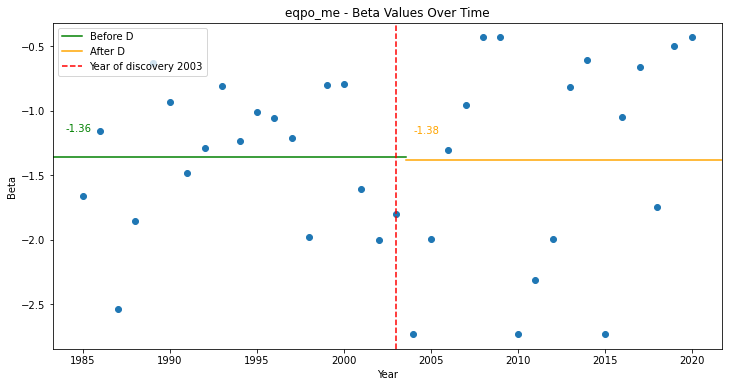

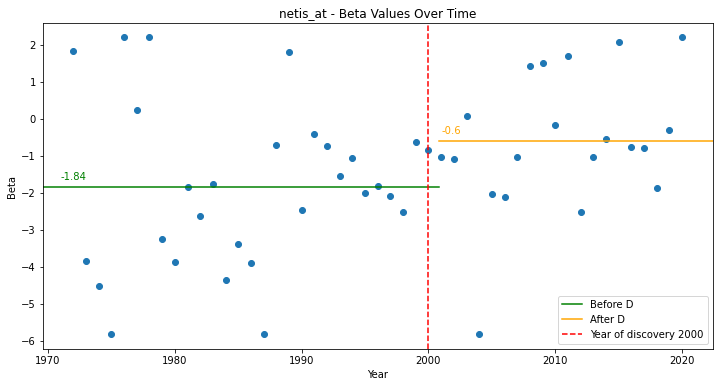

Wall time: 29.5 s


In [14]:
%%time
#Get widget value
iso = w_iso.value

#Plotting all characteristics
results_adj_df = get_data(iso)
for c in results_adj_df["Characteristic"].unique():
    plot_charac_adj(results_adj_df, c)

#### 7. Visualization of country repartition
##### 7.a By MSCI Classifications

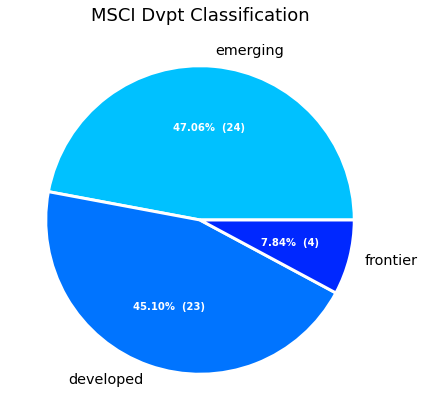

In [15]:
#MSCI - Pct of countries representation
y = class_country[class_country["excntry"].isin(iso_list)]["msci_development"].value_counts().values
mylabels =  class_country[class_country["excntry"].isin(iso_list)]["msci_development"].value_counts().index.tolist()

#Create pie chart
fig, ax = plt.subplots(figsize=(6, 6))

# Colour 
num_colors = len(y)
hue_values = np.linspace(0.55, 0.65, num_colors)
colors = [plt.cm.hsv(h) for h in hue_values]

#Plotting

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

patches, texts, pcts = ax.pie(
    y, labels=mylabels, 
    autopct= make_autopct(y),
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    colors = colors)

# Style just the percent values.
plt.setp(pcts, color='white', fontweight='bold', fontsize="medium")

ax.set_title('MSCI Dvpt Classification', fontsize=18)
plt.tight_layout()

##### 7.b By regions

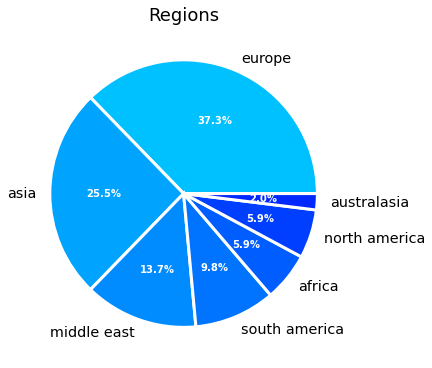

In [16]:
#Regions - Pct of countries representation
y = class_country[class_country["excntry"].isin(iso_list)]["region"].value_counts().values
mylabels =  class_country[class_country["excntry"].isin(iso_list)]["region"].value_counts().index.tolist()

#Create pie chart
fig, ax = plt.subplots(figsize=(6, 6))

# Colour 
num_colors = len(y)
hue_values = np.linspace(0.55, 0.65, num_colors)
colors = [plt.cm.hsv(h) for h in hue_values]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

#Plotting
patches, texts, pcts = ax.pie(
    y, labels=mylabels, autopct='%.1f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    colors = colors)

# Style just the percent values.
plt.setp(pcts, color='white', fontweight='bold', fontsize="medium")

ax.set_title('Regions', fontsize=18)
plt.tight_layout()

#### 8. Create a summary table regrouping all countries

In [17]:
%%time
#Create a df to store the information
summary_df = pd.DataFrame(columns=["Country", "Nb charac"])

for cnt in iso_list:
    results_adj_df = get_data(cnt)
    list_c = []
    for c in results_adj_df["Characteristic"].unique()[:-1]:
        try:
            #In sample period
            in_period = desc_factor[desc_factor["abr_jkp"]==c]["in-sample period"].values[0].split("-")
            start_in = in_period[0]
            disc_year = in_period[1]

            #Avg of betas before and after the discovery
            bef_avg = results_adj_df[(results_adj_df["Characteristic"]==c) 
                                 & (results_adj_df["Year"]<int(disc_year))
                                 & (results_adj_df["Year"]>int(start_in))]["Beta"]

            after_avg = results_adj_df[(results_adj_df["Characteristic"]==c) 
                                   & (results_adj_df["Year"]>int(disc_year))]["Beta"]

            #Check that we have the data first
            if len(bef_avg) != 0 and len(after_avg)!=0:
                #1. Same sign
                if np.sign(bef_avg.mean()) == np.sign(after_avg.mean()):
                    if bef_avg.mean() > after_avg.mean():
                        list_c.append(c)
                #2. Diff sign
                else:
                        list_c.append(c)
        except:
            pass

    #Nb of chara    
    len_c = len(list_c)
    
    #Add to df 
    summary_df.loc[len(summary_df)] = [cnt, len_c]

Wall time: 37.1 s


In [18]:
#Display
sorted_df = summary_df.sort_values("Nb charac", ascending=False)
sorted_df.head(5)

,Country,Nb charac
0,USA,77
8,CAN,62
10,DEU,42
9,AUS,38
11,FRA,35


In [19]:
#Country with zero 
zero_cnt = sorted_df[sorted_df["Nb charac"] == 0]["Country"].tolist()
print("There are ", len(zero_cnt), "countries (out of 96) that doesn't present any decline.")

There are  0 countries (out of 96) that doesn't present any decline.


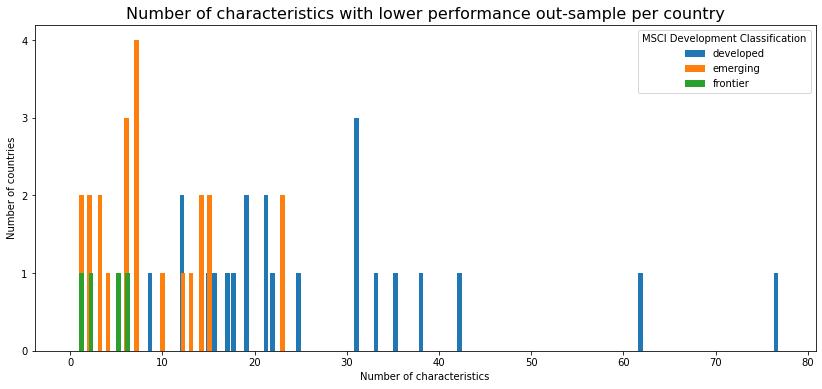

In [20]:
#Use MSCI dvpt classification
temp_list = []
for cnt in sorted_df["Country"]:
    temp_list.append(class_country[class_country["excntry"]==cnt]["msci_development"].values[0])

sorted_df["msci_development"] = temp_list

#Graph
fig, ax = plt.subplots(figsize=(14,6))
for msci in class_country["msci_development"].unique():
    ax.hist(sorted_df[sorted_df["msci_development"] == msci]["Nb charac"], bins=100, width= 0.5)

#Add MSCI development classification
ax.legend(class_country["msci_development"].unique()[:-2], title = "MSCI Development Classification")

#Axis format
ax.set_yticks(range(0,5))

#Legend
ax.set_title("Number of characteristics with lower performance out-sample per country", fontsize=16)
ax.set_ylabel("Number of countries", fontsize=10)
ax.set_xlabel("Number of characteristics", fontsize=10);

In [21]:
sorted_df.to_excel("./lower_perf.xlsx")

#### 9. Characteristics that can be tested per country
Each country does not have the same number of datapoints. We want to know how many characteristic can have an in-sample period. Indeed, for each countries we might not be able to test each of the 153 characteristics. For a characteristic to be tested we require to have at least to data points in the in-sample period.

In [22]:
%%time
test_c_df = pd.DataFrame(columns=["Country", "test_charac"])

for cnt in iso_list:
    results_adj_df = get_data(cnt)
    list_c = []
    for c in results_adj_df["Characteristic"].unique()[:-1]:
            #Discovery date
            in_period = desc_factor[desc_factor["abr_jkp"]==c]["in-sample period"].values[0].split("-")
            disc_year = int(in_period[1])

            #Min date data
            min_date = int(results_adj_df[results_adj_df["Characteristic"]==c]["Year"].min())

            #Check if enough datapoints
            if min_date <= (disc_year-2):
                list_c.append(c)

    #Add to df
    test_c_df.loc[len(test_c_df)] = [cnt, len(list_c)]

#Display
test_c_df.head(5)

Wall time: 36.6 s


,Country,test_charac
0,USA,125
1,CHN,9
2,JPN,25
3,HKG,36
4,GBR,57


In [23]:
#Country with less then 2 characteristic that can be tested
less2_df = class_country[class_country["excntry"].isin(test_c_df[test_c_df["test_charac"]<2]["Country"])]
print("----"*4)
print("MSCI Class")
print("----"*4)
print(less2_df["msci_development"].value_counts())
print("----"*4)
print("Regions")
print("----"*4)
print(less2_df["region"].value_counts())
print("----"*4)
print(less2_df["excntry"].values)

----------------
MSCI Class
----------------
emerging    1
Name: msci_development, dtype: int64
----------------
Regions
----------------
middle east    1
Name: region, dtype: int64
----------------
['SAU']


#### 10. Pct of decrease characteristics

In [24]:
%%time
#Create a df to store the information
summary_df = pd.DataFrame(columns=["Country", "tested", "decrease"])

for cnt in iso_list:
    results_adj_df = get_data(cnt)
    list_c = []#Tested
    list_d = []#Present decrease

    for c in results_adj_df["Characteristic"].unique()[:-1]:
        try:
            #In sample period
            in_period = desc_factor[desc_factor["abr_jkp"]==c]["in-sample period"].values[0].split("-")
            start_in = in_period[0]
            disc_year = in_period[1]

            #Min date data
            min_date = int(results_adj_df[results_adj_df["Characteristic"]==c]["Year"].min())

            #Can be tested?
            if int(min_date) <= (int(disc_year)-2):
                list_c.append(c)
                #Avg of betas before and after the discovery
                bef_avg = results_adj_df[(results_adj_df["Characteristic"]==c) 
                                     & (results_adj_df["Year"]<int(disc_year))
                                     & (results_adj_df["Year"]>int(start_in))]["Beta"]

                after_avg = results_adj_df[(results_adj_df["Characteristic"]==c) 
                                       & (results_adj_df["Year"]>int(disc_year))]["Beta"]

                #Check that we have the data first
                if len(bef_avg) != 0 and len(after_avg)!=0:
                    #1. Same sign
                    if np.sign(bef_avg.mean()) == np.sign(after_avg.mean()):
                        if bef_avg.mean() > after_avg.mean():
                            list_d.append(c)
                    #2. Diff sign
                    else:
                            list_d.append(c)
        except:
            pass

    #Nb of chara    
    len_c = len(list_c)
    len_d = len(list_d)

    #Add to df 
    summary_df.loc[len(summary_df)] = [cnt, len_c, len_d]

Wall time: 36.6 s


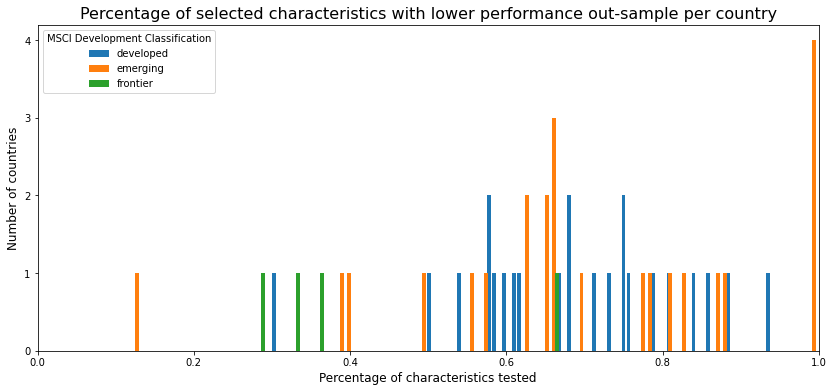

In [25]:
#Add Pct 
summary_df["pct"] = summary_df["decrease"] / summary_df["tested"]

#Use MSCI dvpt classification
temp_list = []
for cnt in summary_df["Country"]:
    temp_list.append(class_country[class_country["excntry"]==cnt]["msci_development"].values[0])

summary_df["msci_development"] = temp_list

#Plot histogram
fig, ax = plt.subplots(figsize=(14,6))

for msci in summary_df["msci_development"].unique():
    ax.hist(summary_df[summary_df["msci_development"] == msci]["pct"], bins=100, width= 0.005)
ax.legend(class_country["msci_development"].unique())

#Add MSCI development classification
ax.legend(class_country["msci_development"].unique(), title = "MSCI Development Classification")

#Axis format
ax.set_yticks(range(0,5))
ax.set_xlim(0,1)

#Legend
ax.set_title("Percentage of selected characteristics with lower performance out-sample per country",  fontsize=16)
ax.set_ylabel("Number of countries", fontsize = 12)
ax.set_xlabel("Percentage of characteristics tested", fontsize = 12);

In [26]:
#Table display
table_df = pd.DataFrame()
groupby_cnt = summary_df.groupby("msci_development")
for msci in summary_df["msci_development"].unique():
    get_cnt = groupby_cnt.get_group(msci)
    df_cnt = pd.DataFrame(get_cnt.groupby(pd.cut(get_cnt["pct"], np.arange(0,1.2,0.2))).count()["pct"])
    df_cnt.columns = [msci]
    if table_df.shape == (0,0):
        table_df = df_cnt
    else:
        table_df = table_df.join(df_cnt)

table_df["Total"] = table_df[list(table_df.columns)].sum(axis=1)

print(table_df)

            developed  emerging  frontier  Total
pct                                             
(0.0, 0.2]          0         1         0      1
(0.2, 0.4]          1         2         3      6
(0.4, 0.6]          6         3         0      9
(0.6, 0.8]         11        10         1     22
(0.8, 1.0]          5         8         0     13
